<center>Mental Health Treatment Prediction AI Project</center>


Introduction  
This notebook explores the use of AI in mental health care, analyzing trends, predicting risks, and providing insights based on available data. It includes data processing, visualization, and machine learning techniques to support mental health analysis.


 I began by importing all required libraries for data analysis, visualization, preprocessing, and machine learning modeling.
 This ensures that I have the tools needed for data manipulation, statistical analysis, and model evaluation.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy import stats
from scipy.stats import randint

# Data preprocessing and model selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Model evaluation metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve

# Stacking classifier
from mlxtend.classifier import StackingClassifier


I loaded the survey dataset from a CSV file to begin the analysis.
This step is crucial as it provides the raw data for all subsequent processing and modeling.

In [ ]:

train_df = pd.read_csv('Survey.csv')

I checked the shape of the dataset to understand its size, which helps in planning the analysis.
This revealed that the dataset contains 1259 rows and 27 columns.

In [ ]:

print(train_df.shape)

(1259, 27)


I generated descriptive statistics for numerical columns to get an overview of the data distribution.
This step highlighted issues like unrealistic 'Age' values (e.g., negative or extremely large numbers).

In [33]:
print(train_df.describe())

                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11


I inspected the dataset's structure and data types using info() to identify column types and missing values.
This showed that most columns are categorical (object type) with some containing missing data.


In [34]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

Analyzing Missing Data
I calculated the total and percentage of missing values per column to assess data quality.
This revealed significant missing data in 'comments' (86.97%), 'state' (40.9%), and 'work_interfere' (20.97%).

In [35]:
#Data CLeaning
# Calculate missing data
missing_data = train_df.isnull().sum().to_frame(name='Total')
missing_data['Percent'] = missing_data['Total'] / len(train_df) * 100
missing_data = missing_data.sort_values(by='Total', ascending=False)

# Display the top 20 columns with missing data
print(missing_data.head(20))

                           Total    Percent
comments                    1095  86.973789
state                        515  40.905481
work_interfere               264  20.969023
self_employed                 18   1.429706
Gender                         0   0.000000
Timestamp                      0   0.000000
Age                            0   0.000000
family_history                 0   0.000000
treatment                      0   0.000000
no_employees                   0   0.000000
Country                        0   0.000000
remote_work                    0   0.000000
tech_company                   0   0.000000
care_options                   0   0.000000
benefits                       0   0.000000
seek_help                      0   0.000000
anonymity                      0   0.000000
leave                          0   0.000000
wellness_program               0   0.000000
mental_health_consequence      0   0.000000


I dropped irrelevant columns ('comments', 'state', 'Timestamp') with high missing rates or low relevance.
I then verified the maximum remaining missing values and displayed the first 5 rows to ensure proper cleaning.

In [36]:
# Dealing with missing data
columns_to_drop = ['comments', 'state', 'Timestamp']
for col in columns_to_drop:
    if col in train_df.columns:
        train_df.drop(col, axis=1, inplace=True)

# Check if there's any missing data remaining
print("Maximum missing values in any column:", train_df.isnull().sum().max())

# Display the first 5 rows of the DataFrame
print(train_df.head(5))

Maximum missing values in any column: 264
   Age  Gender         Country self_employed family_history treatment  \
0   37  Female   United States           NaN             No       Yes   
1   44       M   United States           NaN             No        No   
2   32    Male          Canada           NaN             No        No   
3   31    Male  United Kingdom           NaN            Yes       Yes   
4   31    Male   United States           NaN             No        No   

  work_interfere    no_employees remote_work tech_company  ...   anonymity  \
0          Often            6-25          No          Yes  ...         Yes   
1         Rarely  More than 1000          No           No  ...  Don't know   
2         Rarely            6-25          No          Yes  ...  Don't know   
3          Often          26-100          No          Yes  ...          No   
4          Never         100-500         Yes          Yes  ...  Don't know   

                leave mental_health_consequence ph

I defined default values for different data types and filled missing values accordingly.
 This ensured no NaN values remained, making the dataset suitable for modeling.

In [37]:
# Assign default values for each data type
defaultInt = 0  # Default value for integer columns
defaultString = 'NaN'  # Default value for string columns
defaultFloat = 0.0  # Default value for float columns

# Create lists by data type
intFeatures = ['Age']  # List of integer columns
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                  'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                  'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                  'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                  'seek_help']  # List of string columns
floatFeatures = []  # List of float columns (empty in this case)

# Clean the NaN values in the DataFrame
for feature in train_df.columns:  # Iterate through each column in the DataFrame
    if feature in intFeatures:  # Check if the column is in the integer list
        train_df[feature] = train_df[feature].fillna(defaultInt)  # Fill NaN with default integer value
    elif feature in stringFeatures:  # Check if the column is in the string list
        train_df[feature] = train_df[feature].fillna(defaultString)  # Fill NaN with default string value
    elif feature in floatFeatures:  # Check if the column is in the float list
        train_df[feature] = train_df[feature].fillna(defaultFloat)  # Fill NaN with default float value
    else:
        print(f'Error: Feature "{feature}" not recognized.')  # Print error if the column is not recognized

# Display the first few rows of the cleaned DataFrame
print(train_df.head())

   Age  Gender         Country self_employed family_history treatment  \
0   37  Female   United States           NaN             No       Yes   
1   44       M   United States           NaN             No        No   
2   32    Male          Canada           NaN             No        No   
3   31    Male  United Kingdom           NaN            Yes       Yes   
4   31    Male   United States           NaN             No        No   

  work_interfere    no_employees remote_work tech_company  ...   anonymity  \
0          Often            6-25          No          Yes  ...         Yes   
1         Rarely  More than 1000          No           No  ...  Don't know   
2         Rarely            6-25          No          Yes  ...  Don't know   
3          Often          26-100          No          Yes  ...          No   
4          Never         100-500         Yes          Yes  ...  Don't know   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat 

I examined unique values in the 'Gender' column to understand its diversity.
 This step identified a wide range of gender inputs needing standardization.

In [38]:
#Clean 'Gender'
gender = train_df['Gender'].unique()
print(gender)

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


I created a mapping to standardize gender into 'male', 'female', and 'trans' categories.
This simplified the dataset and improved consistency for modeling.

In [39]:
# Define gender groups
gender_mapping = {
    **{term: 'male' for term in ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man", "msle", "mail", "malr", "cis man", "Cis Male", "cis male"]},
    **{term: 'female' for term in ["cis female", "f", "female", "woman", "femake", "female ", "cis-female/femme", "female (cis)", "femail"]},
    **{term: 'trans' for term in ["trans-female", "something kinda male?", "queer/she/they", "non-binary", "nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]}
}

# Standardize gender values using a dictionary mapping
train_df['Gender'] = train_df['Gender'].str.lower().map(gender_mapping).fillna(train_df['Gender'])

# Remove irrelevant entries
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

# Print unique values in the 'Gender' column
print(train_df['Gender'].unique())

['female' 'male' 'trans']


I implemented a function to adjust unrealistic 'Age' values and created age ranges for better analysis.
 This step addressed outliers (e.g., negative or excessively large ages) by capping them within a reasonable range.

In [40]:
# Function to adjust ages
def adjust_age(age, median_age):
    if age < 18 or age > 120:
        return median_age
    return age

# Fill missing 'Age' values with the median
median_age = train_df['Age'].median()
train_df['Age'] = train_df['Age'].fillna(median_age)

# Apply the function to adjust ages
train_df['Age'] = train_df['Age'].apply(lambda x: adjust_age(x, median_age))

# Create age ranges using pd.cut
age_bins = [0, 20, 30, 65, 100]
age_labels = ["0-20", "21-30", "31-65", "66-100"]
train_df['age_range'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Display the updated DataFrame
print(train_df[['Age', 'age_range']].head())


    Age age_range
0  37.0     31-65
1  44.0     31-65
2  32.0     31-65
3  31.0     31-65
4  31.0     31-65


I noticed that only 0.014% of 'self_employed' values were missing, so I decided to replace 'NaN' with 'No'.
This ensures consistency in the dataset while minimally impacting the data distribution.

In [ ]:

#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


I observed that 0.20% of 'work_interfere' values were missing, so I replaced 'NaN' with "Don't know".
This choice aligns with the categorical nature of the column and provides a meaningful default.

In [42]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


# Encoding Data

I created a dictionary to store LabelEncoders for each feature to encode categorical data.
This step is essential for preparing the dataset for machine learning models that require numerical inputs.

In [43]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue

for key, value in labelDict.items():
    print(key, value)


label_Age [np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(48.0), np.float64(49.0), np.float64(50.0), np.float64(51.0), np.float64(53.0), np.float64(54.0), np.float64(55.0), np.float64(56.0), np.float64(57.0), np.float64(58.0), np.float64(60.0), np.float64(61.0), np.float64(62.0), np.float64(65.0), np.float64(72.0)]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Ri

In [44]:
#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [45]:
#Testing there aren't any missing data
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
Age                            0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0      0.0
obs_consequence                0  

# **Covariance Matrix. Variability comparison between categories of variables**

I generated a correlation matrix to analyze relationships between features. The heatmap visually represents the correlations.

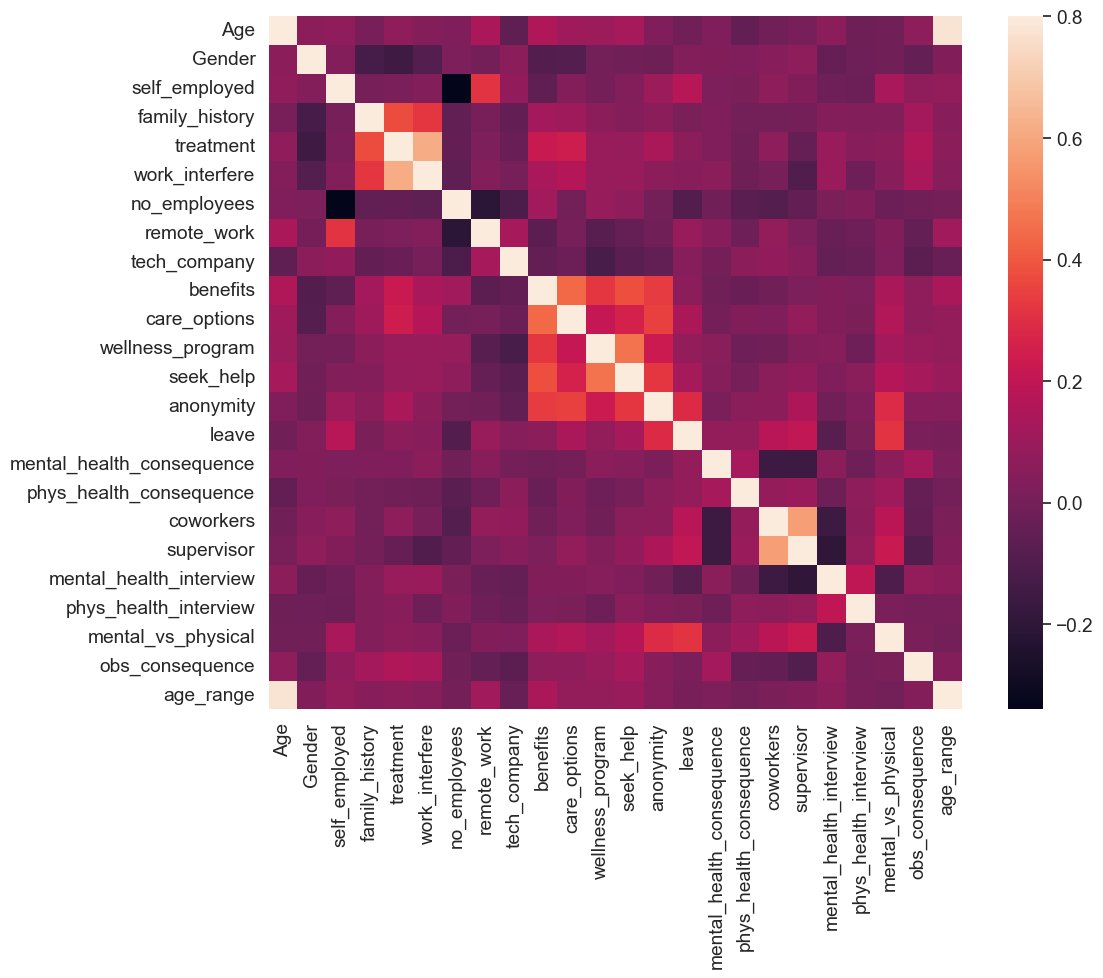

In [46]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

I created a heatmap to visualize the top 10 features most correlated with "treatment," helping identify key relationships in the dataset.

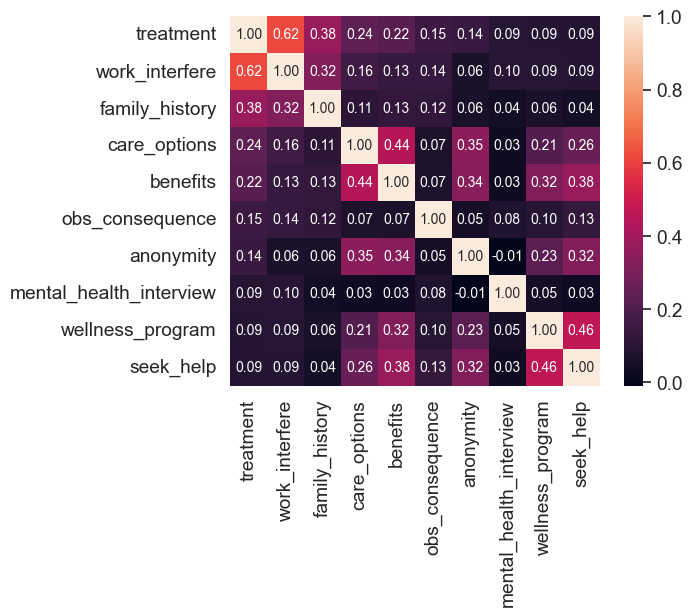

In [47]:
#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# **Some charts to see data relationship**

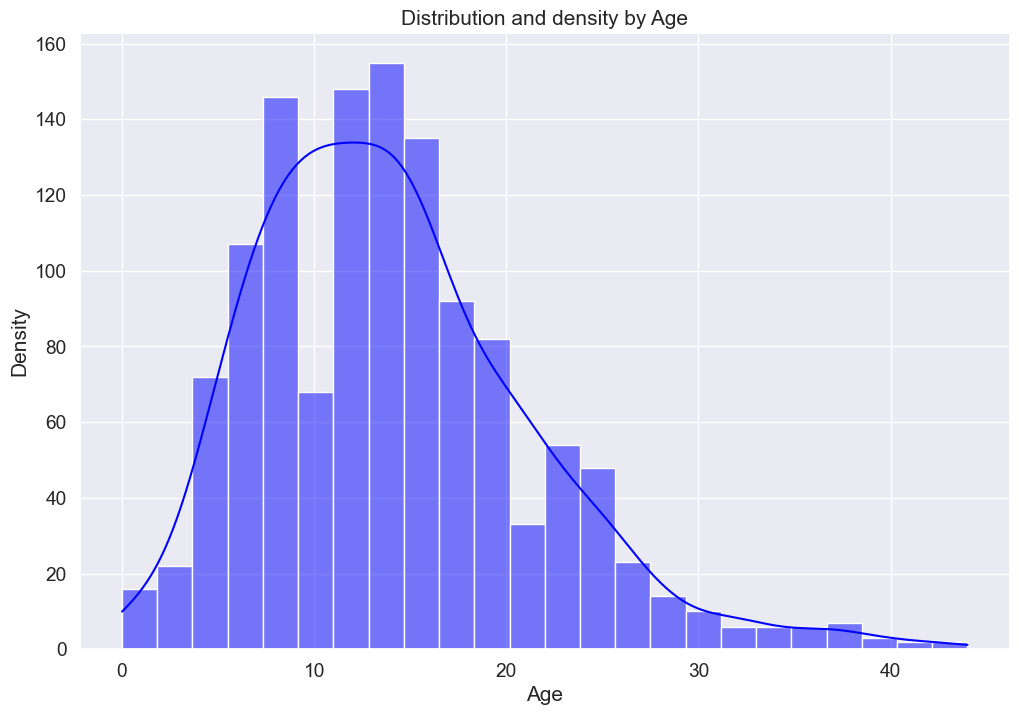

In [48]:
# Distribution and density by Age
plt.figure(figsize=(12, 8))
sns.histplot(train_df["Age"], bins=24, kde=True, color='blue')
plt.title("Distribution and density by Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

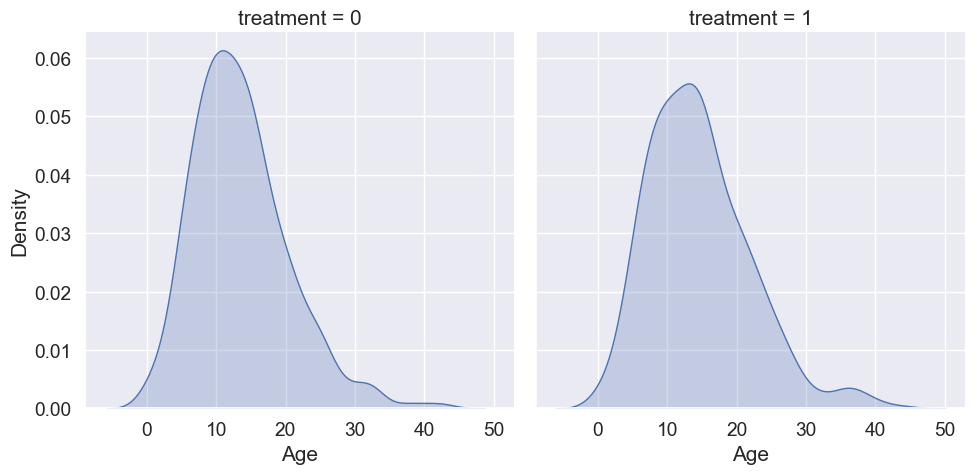

In [49]:
# Separate by treatment using FacetGrid
g = sns.FacetGrid(train_df, col='treatment', height=5)
g.map(sns.kdeplot, "Age", fill=True)  # Use `kdeplot` for density plots
g.set_axis_labels("Age", "Density")
plt.show()

I plotted the count of people treated or not with custom colors, labeled the bars, and displayed the total distribution of the "treatment" variable.

Total Distribution:
treatment
1    635
0    622
Name: count, dtype: int64


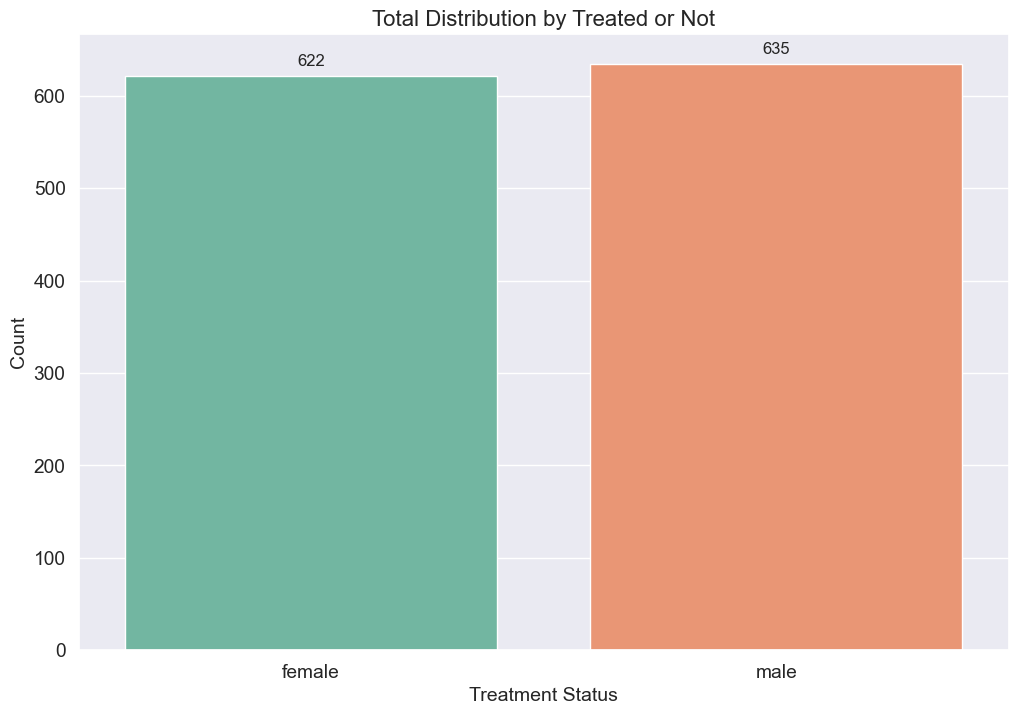

In [50]:
# Plot the count of people treated or not with custom colors
plt.figure(figsize=(12, 8))
g = sns.countplot(x="treatment", data=train_df, hue="treatment", palette="Set2", legend=False)  # Assign `hue` and set `legend=False`

# Ensure the number of labels matches the number of unique values in 'treatment'
unique_treatments = train_df['treatment'].unique()
labels = labelDict['label_Gender'][:len(unique_treatments)]  # Slice labels to match the number of unique treatments
g.set_xticks(range(len(unique_treatments)))  # Set fixed ticks
g.set_xticklabels(labels)

# Add title and labels
plt.title('Total Distribution by Treated or Not', fontsize=16)
plt.xlabel('Treatment Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Annotate the bars with their counts
for p in g.patches:
    g.annotate(f'{int(p.get_height())}',
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext=(0, 10),
               textcoords='offset points',
               fontsize=12)

# Print total distribution
total_distribution = train_df['treatment'].value_counts()
print("Total Distribution:")
print(total_distribution)

plt.show()

I created a nested barplot to visualize the probability of a mental health condition across different age ranges and genders, with customized labels and a modified legend.

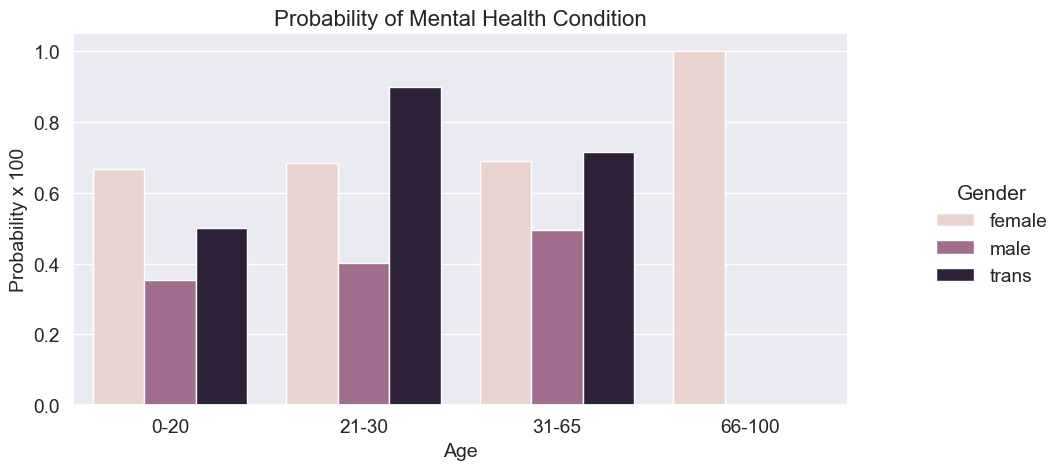

In [51]:
# Define labels for age ranges
o = labelDict['label_age_range']

# Create a nested barplot using sns.catplot
g = sns.catplot(
    x="age_range",
    y="treatment",
    hue="Gender",
    data=train_df,
    kind="bar",
    errorbar=None,  # Use `errorbar=None` instead of `ci=None`
    height=5,  # Use `height` instead of `size`
    aspect=2,
    legend_out=True
)

# Set x-tick labels
g.set_xticklabels(o)

# Add title and axis labels
plt.title('Probability of Mental Health Condition', fontsize=16)
plt.ylabel('Probability x 100', fontsize=14)
plt.xlabel('Age', fontsize=14)

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

# Adjust layout
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

I created a nested barplot to visualize the probability of a mental health condition based on family history and gender, with customized labels and a modified legend.

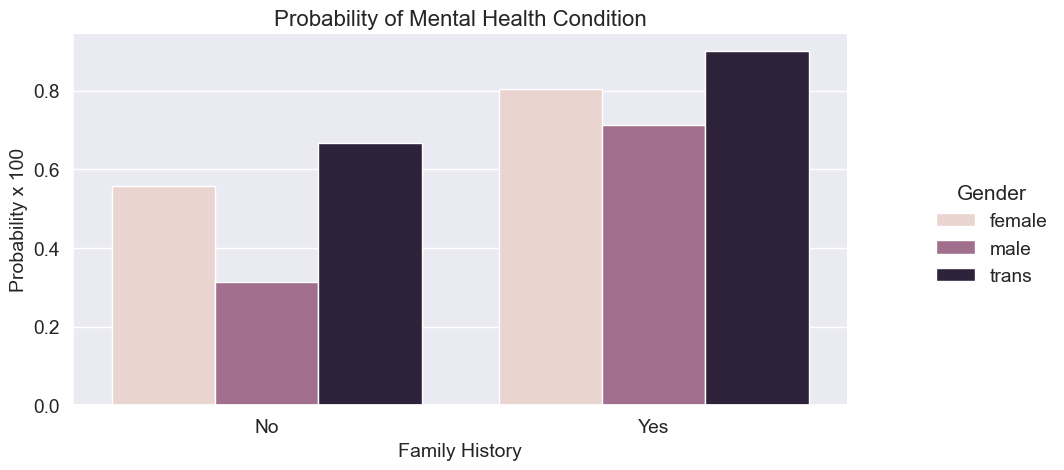

In [52]:
# Define labels for family history
o = labelDict['label_family_history']

# Create a nested barplot using sns.catplot
g = sns.catplot(
    x="family_history",
    y="treatment",
    hue="Gender",
    data=train_df,
    kind="bar",
    errorbar=None,  # Use `errorbar=None` instead of `ci=None`
    height=5,  # Use `height` instead of `size`
    aspect=2,
    legend_out=True
)

# Set x-tick labels
g.set_xticklabels(o)

# Add title and axis labels
plt.title('Probability of Mental Health Condition', fontsize=16)
plt.ylabel('Probability x 100', fontsize=14)
plt.xlabel('Family History', fontsize=14)

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

# Adjust layout
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()


I created a nested barplot to visualize the probability of a mental health condition based on care options and gender, with customized labels and a modified legend.

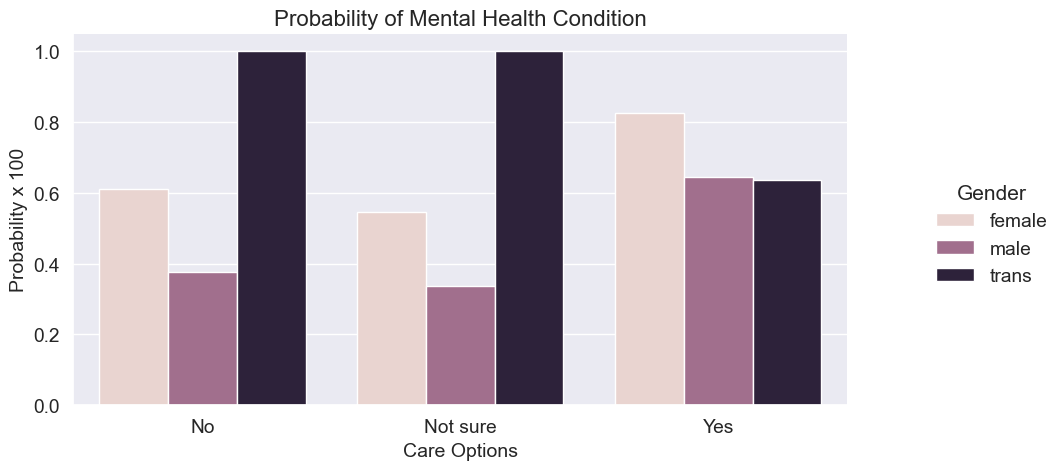

In [53]:
#Barplot to show lables for care options
# Define labels for care options
o = labelDict['label_care_options']

# Create a nested barplot using sns.catplot
g = sns.catplot(
    x="care_options",
    y="treatment",
    hue="Gender",
    data=train_df,
    kind="bar",
    errorbar=None,  # Use `errorbar=None` instead of `ci=None`
    height=5,  # Use `height` instead of `size`
    aspect=2,
    legend_out=True
)

# Set x-tick labels
g.set_xticklabels(o)

# Add title and axis labels
plt.title('Probability of Mental Health Condition', fontsize=16)
plt.ylabel('Probability x 100', fontsize=14)
plt.xlabel('Care Options', fontsize=14)

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

# Adjust layout
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

I created a nested barplot to visualize the probability of a mental health condition based on benefits and gender, with customized labels and a modified legend.

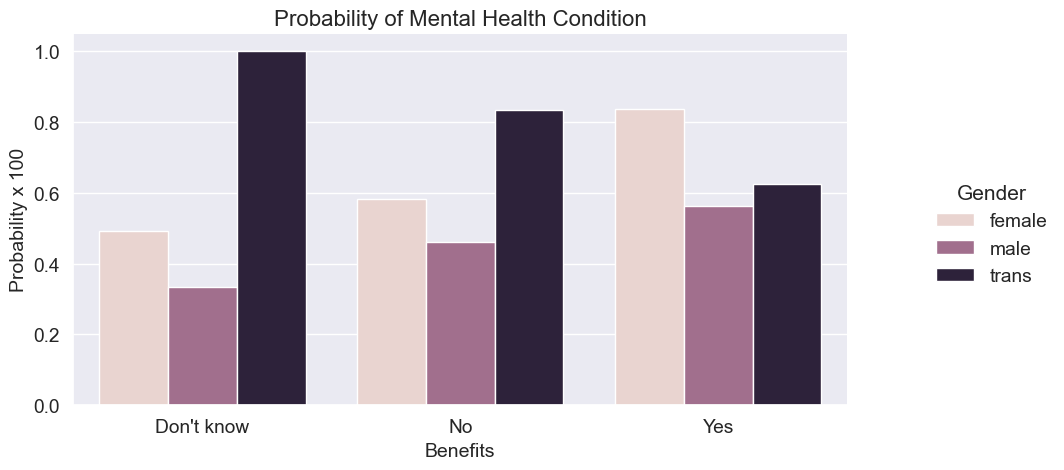

In [54]:
#Barplot to show probabilities of benefit
# Define labels for benefits
o = labelDict['label_benefits']

# Create a nested barplot using sns.catplot
g = sns.catplot(
    x="benefits",  # Corrected to use "benefits" instead of "care_options"
    y="treatment",
    hue="Gender",
    data=train_df,
    kind="bar",
    errorbar=None,  # Use `errorbar=None` instead of `ci=None`
    height=5,  # Use `height` instead of `size`
    aspect=2,
    legend_out=True
)

# Set x-tick labels
g.set_xticklabels(o)

# Add title and axis labels
plt.title('Probability of Mental Health Condition', fontsize=16)
plt.ylabel('Probability x 100', fontsize=14)
plt.xlabel('Benefits', fontsize=14)

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

# Adjust layout
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

I created a nested barplot to visualize the probability of a mental health condition based on work interference and gender, with custom labels and legend adjustments.

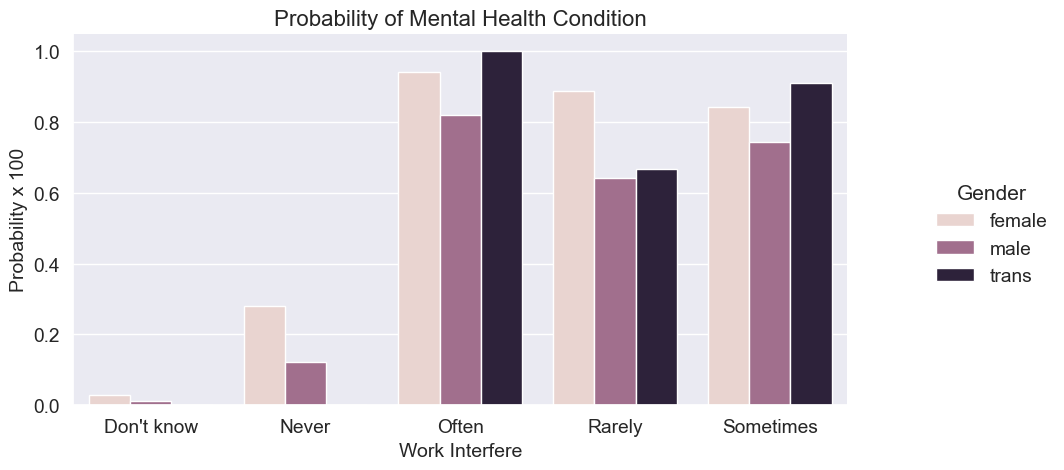

In [ ]:
# Define labels for work interfere
o = labelDict['label_work_interfere']

# Ensure the number of labels matches the number of unique values in 'work_interfere'
unique_work_interfere = train_df['work_interfere'].unique()
if len(o) != len(unique_work_interfere):
    raise ValueError(f"The number of labels ({len(o)}) does not match the number of unique values in 'work_interfere' ({len(unique_work_interfere)}).")

# Create a nested barplot using sns.catplot
g = sns.catplot(
    x="work_interfere",
    y="treatment",
    hue="Gender",
    data=train_df,
    kind="bar",
    errorbar=None,  # Use `errorbar=None` instead of `ci=None`
    height=5,  # Use `height` instead of `size`
    aspect=2,
    legend_out=True
)

# Set x-tick labels
g.set_xticklabels(o)

# Add title and axis labels
plt.title('Probability of Mental Health Condition', fontsize=16)
plt.ylabel('Probability x 100', fontsize=14)
plt.xlabel('Work Interfere', fontsize=14)

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

# Scaling and Fitting

I scaled the "Age" feature using MinMaxScaler to normalize the values within a specific range.

In [56]:
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


I split the dataset into training and testing sets, defining the features and target variables. I also created dictionaries for storing the results of the final graph and model evaluations.

In [57]:
#splitting dataset
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

I built a random forest model to compute feature importances and plotted the results, highlighting the most influential features in the dataset.

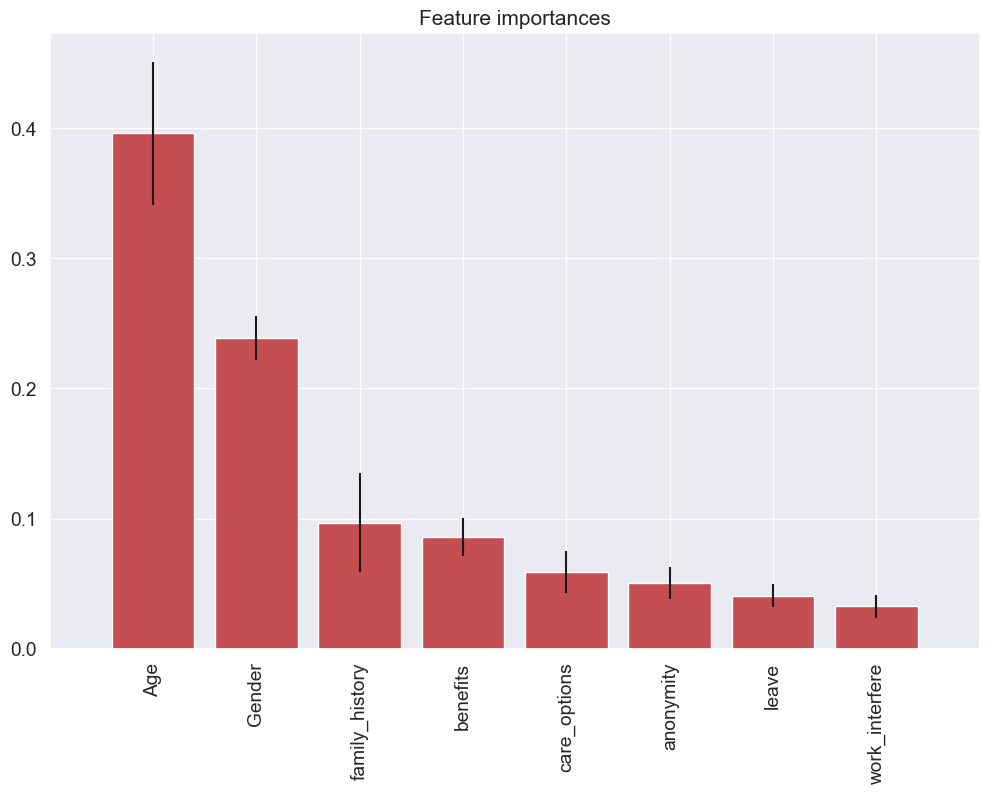

In [58]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

# **Tuning**

I built a Logistic Regression model to classify the synthetic dataset, then evaluated its performance using several metrics. These included accuracy, confusion matrix, precision, false positive rate, AUC score, and cross-validated AUC. I also visualized the model's performance with a confusion matrix heatmap, ROC curve, and histogram of predicted probabilities. To further assess the model, I adjusted the classification threshold and evaluated the impact on the confusion matrix and predicted probabilities.

Accuracy: 0.85
Null accuracy:
 1    155
0    145
Name: count, dtype: int64
Percentage of ones: 0.5166666666666667
Percentage of zeros: 0.4833333333333333
True: [1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1]
Pred: [1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1]


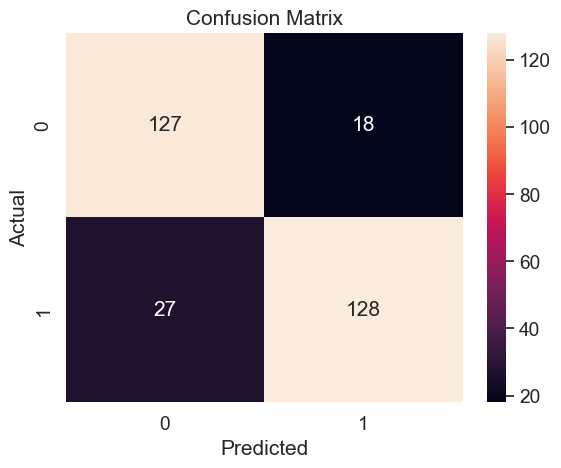

Classification Accuracy: 0.85
Classification Error: 0.15000000000000002
False Positive Rate: 0.12413793103448276
Precision: 0.8767123287671232
AUC Score: 0.8508342602892102
Cross-validated AUC: 0.9284399999999999


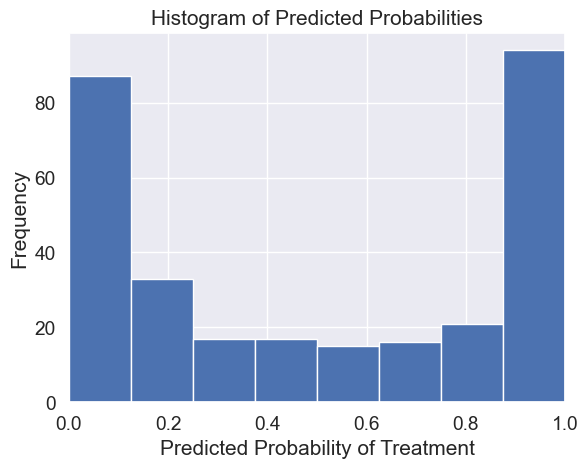

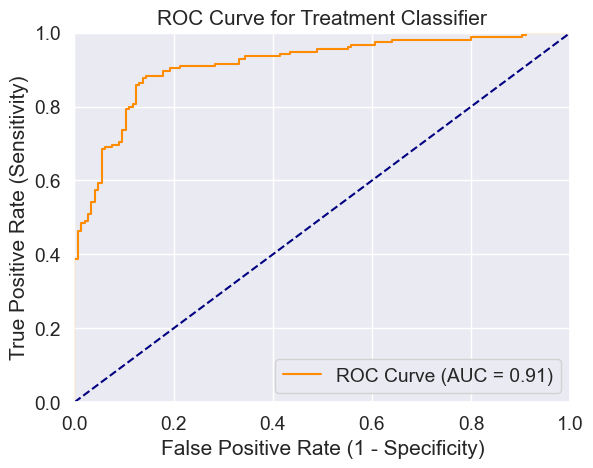

First 10 predicted probabilities (threshold = 0.3):
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
Confusion Matrix (Threshold = 0.3):
 [[114  31]
 [ 15 140]]


0.85

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Generate predictions
y_pred_class = model.predict(X_test)

# Evaluate the model
def evalClassModel(model, X_test, y_test, y_pred_class, plot=False):
    
    # Ensure y_test is a Pandas Series for value_counts()
    if not hasattr(y_test, 'value_counts'):
        y_test = pd.Series(y_test)

    # Classification accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Accuracy:', accuracy)

    # Null accuracy: accuracy achieved by always predicting the most frequent class
    print('Null accuracy:\n', y_test.value_counts())

    # Percentage of ones and zeros
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:', 1 - y_test.mean())

    # Comparing true and predicted values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])

    # Confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Visualize confusion matrix
    sns.heatmap(confusion, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Metrics computed from confusion matrix
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - accuracy)
    print('False Positive Rate:', FP / float(TN + FP))
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))

    # Cross-validated AUC (use full dataset, not just test set)
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())

    # Predicted probabilities
    try:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        print("Model does not support predict_proba. Skipping probability-based metrics.")
        return accuracy

    if plot:
        # Histogram of predicted probabilities
        plt.hist(y_pred_prob, bins=8)
        plt.xlim(0, 1)
        plt.title('Histogram of Predicted Probabilities')
        plt.xlabel('Predicted Probability of Treatment')
        plt.ylabel('Frequency')
        plt.show()

        # ROC Curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
        roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC Curve for Treatment Classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()

    # Adjusting classification threshold
    y_pred_class_adj = binarize(y_pred_prob.reshape(-1, 1), threshold=0.3).ravel()
    print('First 10 predicted probabilities (threshold = 0.3):\n', y_pred_class_adj[0:10])

    # Confusion matrix for adjusted threshold
    confusion_adj = metrics.confusion_matrix(y_test, y_pred_class_adj)
    print('Confusion Matrix (Threshold = 0.3):\n', confusion_adj)

    return accuracy

# Call the function
evalClassModel(model, X_test, y_test, y_pred_class, plot=True)

# **Tuning with cross validation score**

I built a K-Nearest Neighbors (KNN) model, tuned the number of neighbors (K) using cross-validation, and visualized the results. By testing K values from 1 to 30, I found the optimal K that maximizes accuracy. The plot helped identify the best K for the model, ensuring optimal performance in classification tasks.

Cross-validated accuracy scores for each K:
K = 1: Accuracy = 0.7640
K = 2: Accuracy = 0.7690
K = 3: Accuracy = 0.8160
K = 4: Accuracy = 0.8030
K = 5: Accuracy = 0.8110
K = 6: Accuracy = 0.8050
K = 7: Accuracy = 0.8230
K = 8: Accuracy = 0.8220
K = 9: Accuracy = 0.8280
K = 10: Accuracy = 0.8260
K = 11: Accuracy = 0.8380
K = 12: Accuracy = 0.8290
K = 13: Accuracy = 0.8490
K = 14: Accuracy = 0.8400
K = 15: Accuracy = 0.8430
K = 16: Accuracy = 0.8440
K = 17: Accuracy = 0.8450
K = 18: Accuracy = 0.8420
K = 19: Accuracy = 0.8490
K = 20: Accuracy = 0.8400
K = 21: Accuracy = 0.8520
K = 22: Accuracy = 0.8490
K = 23: Accuracy = 0.8510
K = 24: Accuracy = 0.8500
K = 25: Accuracy = 0.8560
K = 26: Accuracy = 0.8500
K = 27: Accuracy = 0.8550
K = 28: Accuracy = 0.8520
K = 29: Accuracy = 0.8560
K = 30: Accuracy = 0.8520


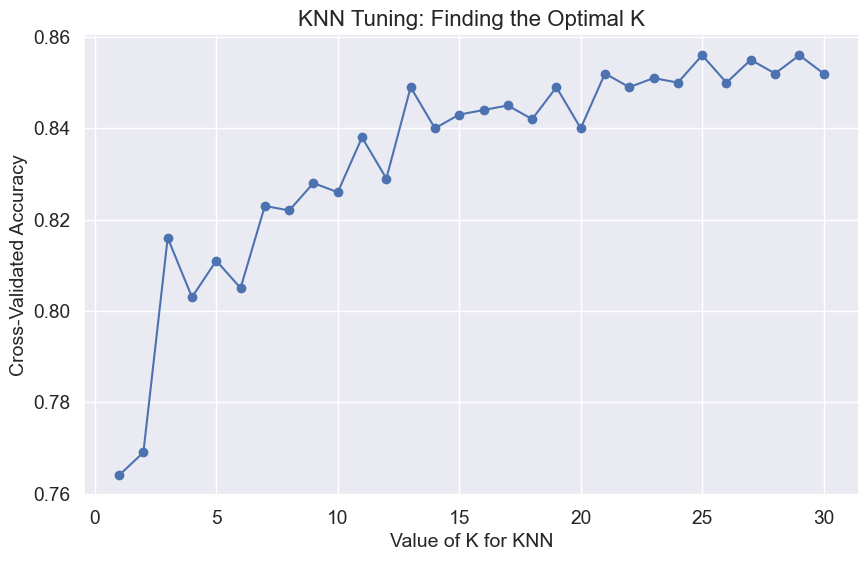

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def tuningCV(X, y):
    """
    Tune the value of K for KNN using cross-validation and plot the results.

    Parameters:
    - X: Feature matrix (numpy array or pandas DataFrame).
    - y: Target labels (numpy array or pandas Series).
    """
    # Search for an optimal value of K for KNN
    k_range = list(range(1, 31))  # Range of K values to test (1 to 30)
    k_scores = []  # List to store cross-validated accuracy scores

    # Iterate over each value of K
    for k in k_range:
        # Create a KNN model with the current K value
        knn = KNeighborsClassifier(n_neighbors=k)

        # Perform 10-fold cross-validation and compute accuracy scores
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

        # Append the mean accuracy score to the list
        k_scores.append(scores.mean())

    # Print the cross-validated accuracy scores for each K
    print("Cross-validated accuracy scores for each K:")
    for k, score in zip(k_range, k_scores):
        print(f"K = {k}: Accuracy = {score:.4f}")

    # Plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Value of K for KNN', fontsize=14)
    plt.ylabel('Cross-Validated Accuracy', fontsize=14)
    plt.title('KNN Tuning: Finding the Optimal K', fontsize=16)
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Call the function to tune KNN
    tuningCV(X, y)

# Tuning with **GridSearchCV** **bold text**

I built and tuned a K-Nearest Neighbors (KNN) model using **GridSearchCV** to find the optimal value of K. By searching for K values from 1 to 30, I evaluated the model using 10-fold cross-validation. The results were plotted to visualize the accuracy across different K values, and the optimal K was selected based on the highest mean validation score. The grid search also provided the best parameters, score, and estimator for the model.

Range of K values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Parameter grid: {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
Cross-validation results:
Parameters: {'n_neighbors': 1}, Mean Validation Score: 0.7640
Parameters: {'n_neighbors': 2}, Mean Validation Score: 0.7690
Parameters: {'n_neighbors': 3}, Mean Validation Score: 0.8160
Parameters: {'n_neighbors': 4}, Mean Validation Score: 0.8030
Parameters: {'n_neighbors': 5}, Mean Validation Score: 0.8110
Parameters: {'n_neighbors': 6}, Mean Validation Score: 0.8050
Parameters: {'n_neighbors': 7}, Mean Validation Score: 0.8230
Parameters: {'n_neighbors': 8}, Mean Validation Score: 0.8220
Parameters: {'n_neighbors': 9}, Mean Validation Score: 0.8280
Parameters: {'n_neighbors': 10}, Mean Validation Score: 0.8260
Parameters: {'n_neighbors': 11}, Mean Validation Score: 0.8380
Parameters: {'

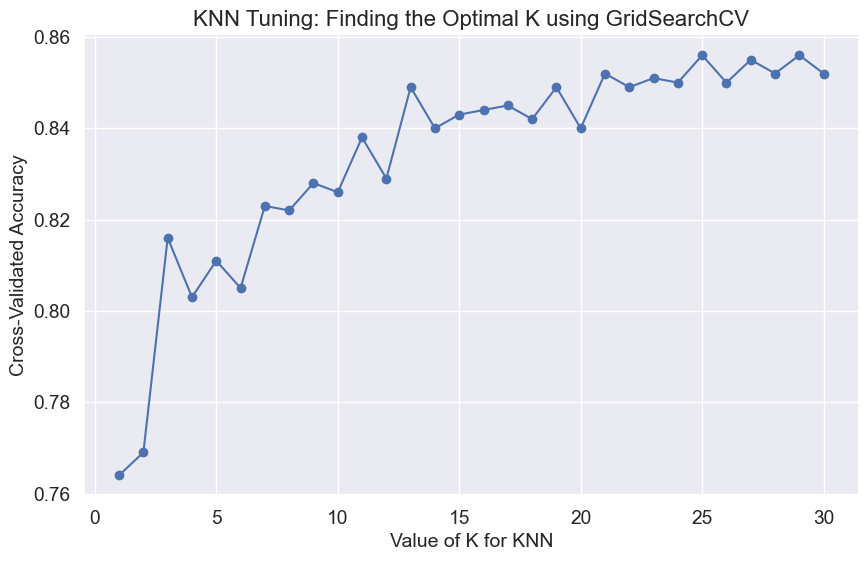

GridSearch best score: 0.8560000000000001
GridSearch best parameters: {'n_neighbors': 25}
GridSearch best estimator: KNeighborsClassifier(n_neighbors=25)


In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def tuningGridSearch(X, y):
    """
    Tune the value of K for KNN using GridSearchCV and plot the results.

    Parameters:
    - X: Feature matrix (numpy array or pandas DataFrame).
    - y: Target labels (numpy array or pandas Series).
    """
    # Define the range of K values to test
    k_range = list(range(1, 31))  # K values from 1 to 30
    print("Range of K values:", k_range)

    # Create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print("Parameter grid:", param_grid)

    # Instantiate the KNN classifier
    knn = KNeighborsClassifier()

    # Instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # Fit the grid with data
    grid.fit(X, y)

    # Access the cross-validation results
    cv_results = grid.cv_results_

    # Print the parameters and mean validation scores for each K
    print("Cross-validation results:")
    for params, mean_score in zip(cv_results['params'], cv_results['mean_test_score']):
        print(f"Parameters: {params}, Mean Validation Score: {mean_score:.4f}")

    # Create a list of the mean scores only
    grid_mean_scores = cv_results['mean_test_score']
    print("Mean validation scores for each K:", grid_mean_scores)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, grid_mean_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Value of K for KNN', fontsize=14)
    plt.ylabel('Cross-Validated Accuracy', fontsize=14)
    plt.title('KNN Tuning: Finding the Optimal K using GridSearchCV', fontsize=16)
    plt.grid(True)
    plt.show()

    # Examine the best model
    print('GridSearch best score:', grid.best_score_)
    print('GridSearch best parameters:', grid.best_params_)
    print('GridSearch best estimator:', grid.best_estimator_)

# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Call the function to tune KNN using GridSearchCV
    tuningGridSearch(X, y)

# **Tuning with Multiple Parameter**

I created a function to tune multiple parameters for a **K-Nearest Neighbors (KNN)** classifier using **GridSearchCV**. This function allows for the optimization of both the **K value** (ranging from 1 to 30) and the **weights** parameter (either 'uniform' or 'distance'). The grid search evaluates combinations of these parameters using 10-fold cross-validation. The results are printed, showing the mean validation scores for each parameter combination, and the best parameters and score are identified. This approach ensures we can identify the optimal KNN configuration.

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def tuningMultParam(knn, X, y):
    """
    Tune multiple parameters for KNN using GridSearchCV and print the results.

    Parameters:
    - knn: The KNN classifier.
    - X: Feature matrix (numpy array or pandas DataFrame).
    - y: Target labels (numpy array or pandas Series).
    """
    # Define the parameter values that should be searched
    k_range = list(range(1, 31))  # K values from 1 to 30
    weight_options = ['uniform', 'distance']  # Weight options for KNN

    # Create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print("Parameter grid:", param_grid)

    # Instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y)

    # Access the cross-validation results
    cv_results = grid.cv_results_

    # Print the complete results
    print("Cross-validation results:")
    for params, mean_score in zip(cv_results['params'], cv_results['mean_test_score']):
        print(f"Parameters: {params}, Mean Validation Score: {mean_score:.4f}")

    # Examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Instantiate the KNN classifier
    knn = KNeighborsClassifier()

    # Call the function to tune KNN using GridSearchCV
    tuningMultParam(knn, X, y)

Parameter grid: {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}
Cross-validation results:
Parameters: {'n_neighbors': 1, 'weights': 'uniform'}, Mean Validation Score: 0.7640
Parameters: {'n_neighbors': 1, 'weights': 'distance'}, Mean Validation Score: 0.7640
Parameters: {'n_neighbors': 2, 'weights': 'uniform'}, Mean Validation Score: 0.7690
Parameters: {'n_neighbors': 2, 'weights': 'distance'}, Mean Validation Score: 0.7640
Parameters: {'n_neighbors': 3, 'weights': 'uniform'}, Mean Validation Score: 0.8160
Parameters: {'n_neighbors': 3, 'weights': 'distance'}, Mean Validation Score: 0.8160
Parameters: {'n_neighbors': 4, 'weights': 'uniform'}, Mean Validation Score: 0.8030
Parameters: {'n_neighbors': 4, 'weights': 'distance'}, Mean Validation Score: 0.8080
Parameters: {'n_neighbors': 5, 'weights': 'uniform'}, Mean Validation Score: 0.8110
Parameters: {'n_neighbors': 5, 'w

## **Evaluating Models**

#Logistic Regression

I trained a **Logistic Regression** model and evaluated its performance using accuracy, precision, confusion matrix, AUC score, and visualizations like the **ROC curve** and **probability histogram**. The **methodDict** stores the accuracy score for comparison with other models.

Accuracy: 0.85
Null accuracy:
 1    155
0    145
Name: count, dtype: int64
Percentage of ones: 0.5166666666666667
Percentage of zeros: 0.4833333333333333
True: [1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1]
Pred: [1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1]


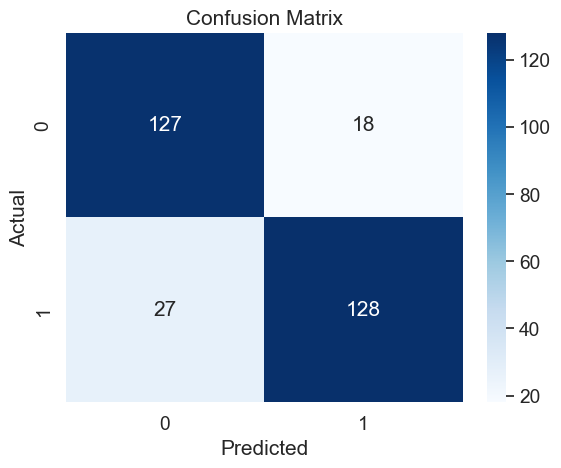

Classification Accuracy: 0.85
Classification Error: 0.15000000000000002
False Positive Rate: 0.12413793103448276
Precision: 0.8767123287671232
AUC Score: 0.8508342602892102
Cross-validated AUC: 0.9284399999999999
First 10 predicted responses:
 [1 1 1 1 1 0 0 1 1 0]
First 10 predicted probabilities of class members:
 [[0.39046333 0.60953667]
 [0.13107074 0.86892926]
 [0.48609053 0.51390947]
 [0.22091062 0.77908938]
 [0.04627634 0.95372366]
 [0.94765481 0.05234519]
 [0.77236324 0.22763676]
 [0.21065295 0.78934705]
 [0.26296255 0.73703745]
 [0.68758235 0.31241765]]
First 10 predicted probabilities:
 [[0.60953667]
 [0.86892926]
 [0.51390947]
 [0.77908938]
 [0.95372366]
 [0.05234519]
 [0.22763676]
 [0.78934705]
 [0.73703745]
 [0.31241765]]


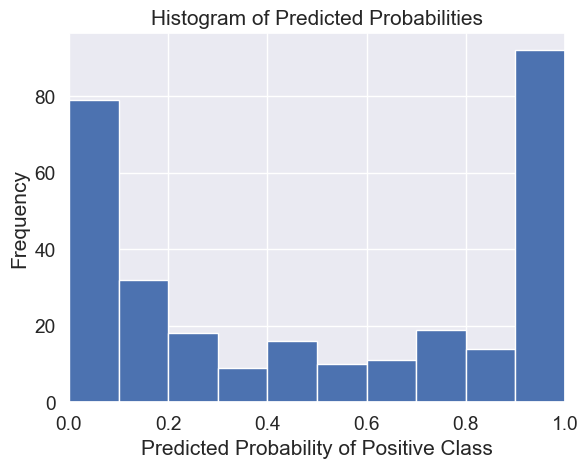

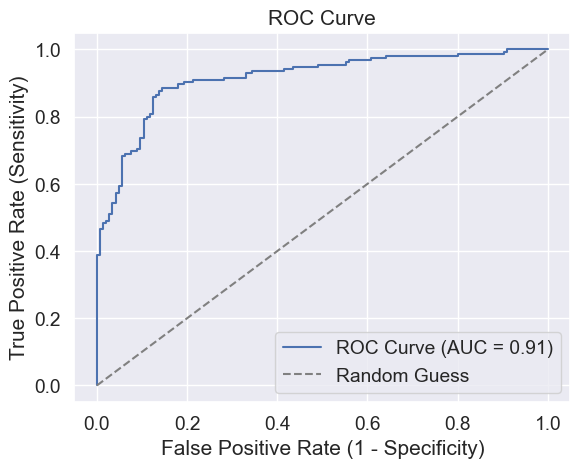

Method Dictionary: {'Log. Regression': 85.0}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Global dictionary to store accuracy scores
methodDict = {}

def evalClassModel(model, X_test, y_test, y_pred_class, plot=False):
   
    # Ensure y_test is a Pandas Series for value_counts()
    if not hasattr(y_test, 'value_counts'):
        y_test = pd.Series(y_test)

    # Classification accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    print('Accuracy:', accuracy)

    # Null accuracy: accuracy achieved by always predicting the most frequent class
    print('Null accuracy:\n', y_test.value_counts())

    # Percentage of ones and zeros
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:', 1 - y_test.mean())

    # Comparing true and predicted values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Visualize confusion matrix
    if plot:
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Metrics computed from confusion matrix
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - accuracy)
    print('False Positive Rate:', FP / float(TN + FP))
    print('Precision:', precision_score(y_test, y_pred_class))
    print('AUC Score:', roc_auc_score(y_test, y_pred_class))

    # Cross-validated AUC (use full dataset, not just test set)
    # Assuming X and y are the full dataset
    # Replace X and y with your full dataset if available
    try:
        print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    except NameError:
        print("Cross-validated AUC: Full dataset (X, y) not provided.")

    # Predicted probabilities
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        print('First 10 predicted responses:\n', y_pred_class[0:10])
        print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])
        print('First 10 predicted probabilities:\n', y_pred_prob[0:10].reshape(-1, 1))

    if plot and hasattr(model, "predict_proba"):
        # Histogram of predicted probabilities
        plt.hist(y_pred_prob, bins=10)
        plt.xlim(0, 1)
        plt.title('Histogram of Predicted Probabilities')
        plt.xlabel('Predicted Probability of Positive Class')
        plt.ylabel('Frequency')
        plt.show()

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return accuracy

def logisticRegression(X_train, y_train, X_test, y_test):
    """
    Train a logistic regression model on the training set and evaluate it on the testing set.

    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training target labels.
    - X_test: Testing feature matrix.
    - y_test: Testing target labels.
    """
    # Train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # Make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)

    # Evaluate the model
    accuracy_score = evalClassModel(logreg, X_test, y_test, y_pred_class, True)

    # Data for final graph
    methodDict['Log. Regression'] = accuracy_score * 100

# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Call the function to train and evaluate logistic regression
    logisticRegression(X_train, y_train, X_test, y_test)

    # Print the results
    print("Method Dictionary:", methodDict)

# **K NeighborClassifier**

In [64]:
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


I tuned the **K-Nearest Neighbors (KNN)** model using **RandomizedSearchCV** to find the best hyperparameters like the number of neighbors and weight options. After training the model, I evaluated its performance on the test set using accuracy, precision, confusion matrix, AUC score, and visualizations (ROC curve, probability histogram). The **methodDict** stores the accuracy score for comparison with other models.

Cross-validation results:
Parameters: {'weights': 'distance', 'n_neighbors': 16}, Mean Validation Score: 0.8571
Parameters: {'weights': 'uniform', 'n_neighbors': 22}, Mean Validation Score: 0.8571
Parameters: {'weights': 'uniform', 'n_neighbors': 18}, Mean Validation Score: 0.8629
Parameters: {'weights': 'uniform', 'n_neighbors': 27}, Mean Validation Score: 0.8600
Parameters: {'weights': 'uniform', 'n_neighbors': 29}, Mean Validation Score: 0.8629
Parameters: {'weights': 'distance', 'n_neighbors': 10}, Mean Validation Score: 0.8343
Parameters: {'weights': 'distance', 'n_neighbors': 22}, Mean Validation Score: 0.8629
Parameters: {'weights': 'uniform', 'n_neighbors': 14}, Mean Validation Score: 0.8543
Parameters: {'weights': 'distance', 'n_neighbors': 12}, Mean Validation Score: 0.8457
Parameters: {'weights': 'uniform', 'n_neighbors': 15}, Mean Validation Score: 0.8586
Rand. Best Score:  0.862857142857143
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 18}
Best scores from 20 r

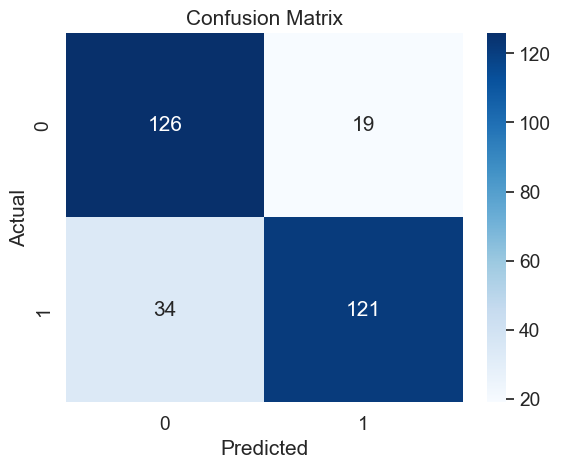

Classification Accuracy: 0.8233333333333334
Classification Error: 0.17666666666666664
False Positive Rate: 0.1310344827586207
Precision: 0.8642857142857143
AUC Score: 0.824805339265851
Cross-validated AUC: 0.92018
First 10 predicted responses:
 [0 1 0 1 1 0 0 1 1 0]
First 10 predicted probabilities of class members:
 [[0.55555556 0.44444444]
 [0.48148148 0.51851852]
 [0.62962963 0.37037037]
 [0.33333333 0.66666667]
 [0.22222222 0.77777778]
 [0.55555556 0.44444444]
 [0.62962963 0.37037037]
 [0.37037037 0.62962963]
 [0.44444444 0.55555556]
 [0.59259259 0.40740741]]
First 10 predicted probabilities:
 [[0.44444444]
 [0.51851852]
 [0.37037037]
 [0.66666667]
 [0.77777778]
 [0.44444444]
 [0.37037037]
 [0.62962963]
 [0.55555556]
 [0.40740741]]


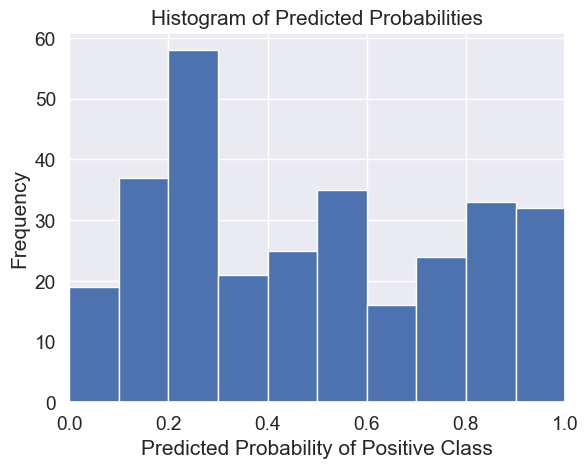

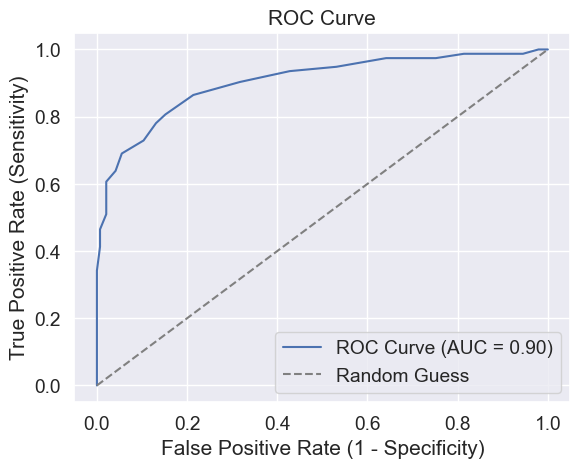

Method Dictionary: {'K-Neighbors': 82.33333333333334}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Global dictionary to store accuracy scores
methodDict = {}

def tuningRandomizedSearchCV(model, param_dist, X, y):
  
    # Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)

    # Access the cross-validation results
    cv_results = rand.cv_results_

    # Print the cross-validation results
    print("Cross-validation results:")
    for params, mean_score in zip(cv_results['params'], cv_results['mean_test_score']):
        print(f"Parameters: {params}, Mean Validation Score: {mean_score:.4f}")

    # Examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)

    # Run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=np.random.randint(1, 1000))
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print("Best scores from 20 runs:", best_scores)

def evalClassModel(model, X_test, y_test, y_pred_class, plot=False):
  
    # Ensure y_test is a Pandas Series for value_counts()
    if not hasattr(y_test, 'value_counts'):
        y_test = pd.Series(y_test)

    # Classification accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    print('Accuracy:', accuracy)

    # Null accuracy: accuracy achieved by always predicting the most frequent class
    print('Null accuracy:\n', y_test.value_counts())

    # Percentage of ones and zeros
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:', 1 - y_test.mean())

    # Comparing true and predicted values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Visualize confusion matrix
    if plot:
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Metrics computed from confusion matrix
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - accuracy)
    print('False Positive Rate:', FP / float(TN + FP))
    print('Precision:', precision_score(y_test, y_pred_class))
    print('AUC Score:', roc_auc_score(y_test, y_pred_class))

    # Cross-validated AUC (use full dataset, not just test set)
    # Assuming X and y are the full dataset
    # Replace X and y with your full dataset if available
    try:
        print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    except NameError:
        print("Cross-validated AUC: Full dataset (X, y) not provided.")

    # Predicted probabilities
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        print('First 10 predicted responses:\n', y_pred_class[0:10])
        print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])
        print('First 10 predicted probabilities:\n', y_pred_prob[0:10].reshape(-1, 1))

    if plot and hasattr(model, "predict_proba"):
        # Histogram of predicted probabilities
        plt.hist(y_pred_prob, bins=10)
        plt.xlim(0, 1)
        plt.title('Histogram of Predicted Probabilities')
        plt.xlabel('Predicted Probability of Positive Class')
        plt.ylabel('Frequency')
        plt.show()

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return accuracy

def Knn(X_train, y_train, X_test, y_test):
    """
    Train a K-Nearest Neighbors (KNN) model on the training set and evaluate it on the testing set.

    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training target labels.
    - X_test: Testing feature matrix.
    - y_test: Testing target labels.
    """
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)

    # Define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']

    # Specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist, X_train, y_train)

    # Train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)

    # Make class predictions for the testing set
    y_pred_class = knn.predict(X_test)

    # Evaluate the model
    accuracy_score = evalClassModel(knn, X_test, y_test, y_pred_class, True)

    # Data for final graph
    methodDict['K-Neighbors'] = accuracy_score * 100

# Example usage
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Call the function to train and evaluate KNN
    Knn(X_train, y_train, X_test, y_test)

    # Print the results
    print("Method Dictionary:", methodDict)

# **Random Forest**

In this code, I train and evaluate a **Random Forest** model using synthetic data. After splitting the data, I fit the model with specified hyperparameters and evaluate it based on **accuracy**, **precision**, and other metrics. The results, including visualizations like the confusion matrix and ROC curve, are stored in a dictionary for comparison.

Accuracy: 0.8433333333333334
Null accuracy:
 1    155
0    145
Name: count, dtype: int64
Percentage of ones: 0.5166666666666667
Percentage of zeros: 0.4833333333333333
True: [1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1]
Pred: [1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1]


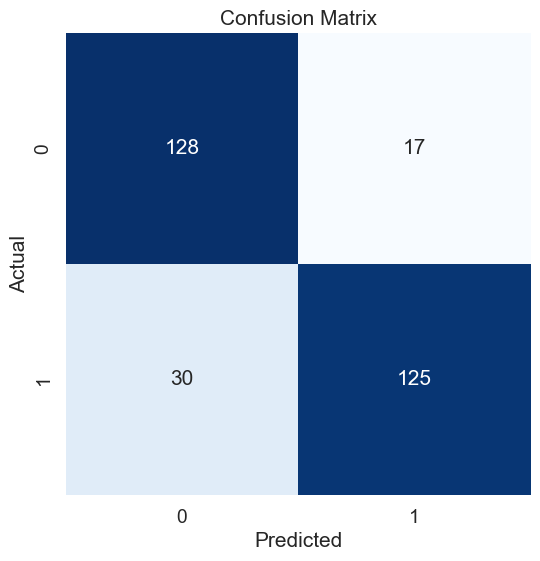

Classification Accuracy: 0.8433333333333334
Classification Error: 0.15666666666666662
False Positive Rate: 0.11724137931034483
Precision: 0.8802816901408451
AUC Score: 0.8446051167964405
First 10 predicted responses:
 [1 1 0 1 1 0 0 1 1 0]
First 10 predicted probabilities of class members:
 [[0.34076887 0.65923113]
 [0.18221512 0.81778488]
 [0.8310122  0.1689878 ]
 [0.01944444 0.98055556]
 [0.08021497 0.91978503]
 [0.95929519 0.04070481]
 [0.75665647 0.24334353]
 [0.18738815 0.81261185]
 [0.25876029 0.74123971]
 [0.58840484 0.41159516]]
First 10 predicted probabilities:
 [[0.65923113]
 [0.81778488]
 [0.1689878 ]
 [0.98055556]
 [0.91978503]
 [0.04070481]
 [0.24334353]
 [0.81261185]
 [0.74123971]
 [0.41159516]]


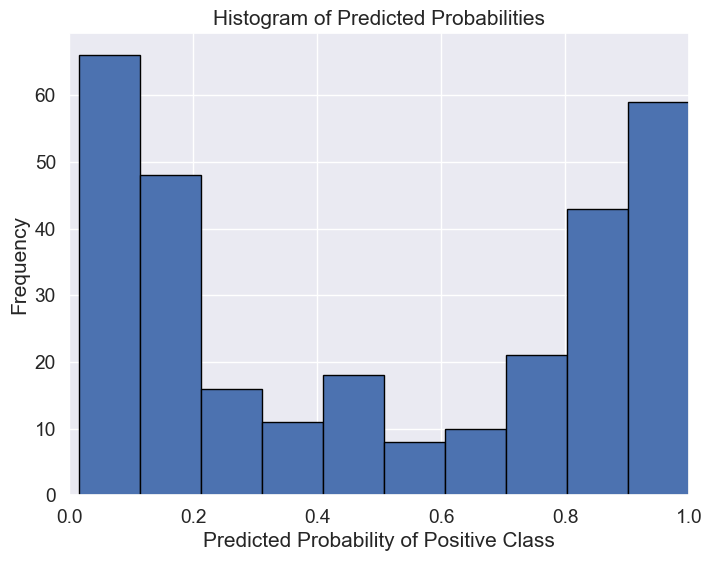

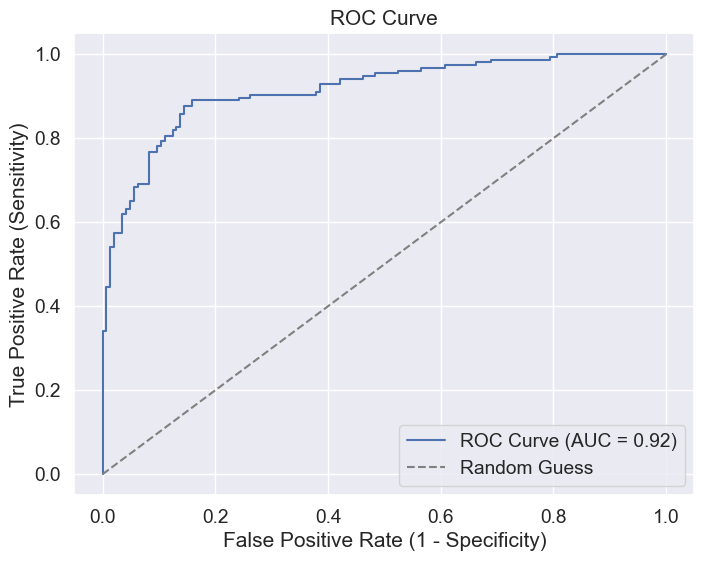

Method Dictionary: {'Random Forest': 84.33333333333334}


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evalClassModel(model, X_test, y_test, y_pred_class, plot=False):
    """
    Evaluate a Random Forest model and return the accuracy score.
    Optionally, plot confusion matrix, histogram of predicted probabilities, and ROC curve.

    Parameters:
    - model: The trained Random Forest model.
    - X_test: Testing feature matrix.
    - y_test: True labels for the test set.
    - y_pred_class: Predicted labels for the test set.
    - plot: Whether to plot additional visualizations (default: False).

    Returns:
    - accuracy_score: Accuracy of the model.
    """
    # Ensure y_test is a Pandas Series for value_counts()
    if not hasattr(y_test, 'value_counts'):
        y_test = pd.Series(y_test)

    # Classification accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    print('Accuracy:', accuracy)

    # Null accuracy: accuracy achieved by always predicting the most frequent class
    print('Null accuracy:\n', y_test.value_counts())

    # Percentage of ones and zeros
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:', 1 - y_test.mean())

    # Comparing true and predicted values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Visualize confusion matrix
    if plot:
        plt.figure(figsize=(6, 6))
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Metrics computed from confusion matrix
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - accuracy)
    print('False Positive Rate:', FP / float(TN + FP))
    print('Precision:', precision_score(y_test, y_pred_class))
    print('AUC Score:', roc_auc_score(y_test, y_pred_class))

    # Predicted probabilities
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        print('First 10 predicted responses:\n', y_pred_class[0:10])
        print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])
        print('First 10 predicted probabilities:\n', y_pred_prob[0:10].reshape(-1, 1))

        if plot:
            # Histogram of predicted probabilities
            plt.figure(figsize=(8, 6))
            plt.hist(y_pred_prob, bins=10, edgecolor='black')
            plt.xlim(0, 1)
            plt.title('Histogram of Predicted Probabilities')
            plt.xlabel('Predicted Probability of Positive Class')
            plt.ylabel('Frequency')
            plt.show()

            # ROC Curve
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            roc_auc = roc_auc_score(y_test, y_pred_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
            plt.xlabel('False Positive Rate (1 - Specificity)')
            plt.ylabel('True Positive Rate (Sensitivity)')
            plt.title('ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
    else:
        print("Model does not support predict_proba.")

    return accuracy

def randomForest(X_train, y_train, X_test, y_test, feature_cols, methodDict):
    """
    Train a Random Forest model on the training set and evaluate it on the testing set.

    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training target labels.
    - X_test: Testing feature matrix.
    - y_test: Testing target labels.
    - feature_cols: List of feature names.
    - methodDict: Dictionary to store accuracy scores.
    """
    # Building and fitting the Random Forest model
    forest = RandomForestClassifier(
        max_depth=None,
        min_samples_leaf=8,
        min_samples_split=2,
        n_estimators=20,
        random_state=1
    )
    my_forest = forest.fit(X_train, y_train)

    # Make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)

    # Evaluate the model
    accuracy_score = evalClassModel(my_forest, X_test, y_test, y_pred_class, True)

    # Data for final graph
    methodDict['Random Forest'] = accuracy_score * 100

    return methodDict

# Example usage:
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define feature columns (for demonstration purposes)
    feature_cols = [f"feature_{i}" for i in range(X.shape[1])]

    # Initialize methodDict
    methodDict = {}

    # Call the function to train and evaluate the random forest
    methodDict = randomForest(X_train, y_train, X_test, y_test, feature_cols, methodDict)

    # Print the results
    print("Method Dictionary:", methodDict)

ADA Boost

I train and evaluate an **AdaBoost** model using a **DecisionTreeClassifier** as the base estimator. I calculate metrics like **accuracy**, **precision**, and **AUC**, and optionally plot the confusion matrix, predicted probabilities, and ROC curve. The results are stored in a dictionary for easy comparison with other models.

Accuracy: 0.85
Null accuracy:
 1    155
0    145
Name: count, dtype: int64
Percentage of ones: 0.5166666666666667
Percentage of zeros: 0.4833333333333333
True: [1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1]
Pred: [1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1]


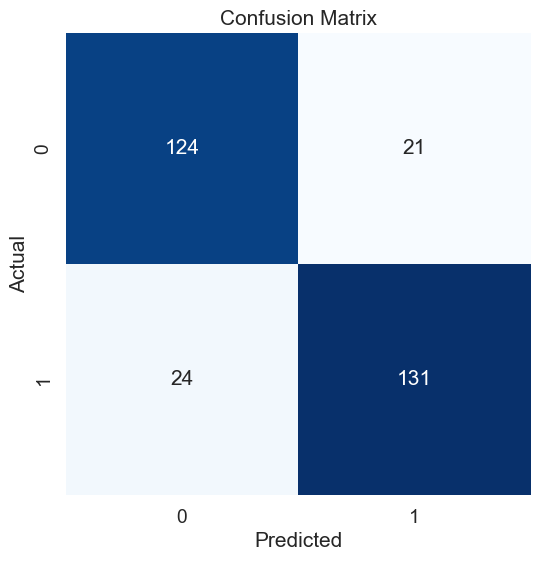

Classification Accuracy: 0.85
Classification Error: 0.15000000000000002
False Positive Rate: 0.14482758620689656
Precision: 0.8618421052631579
AUC Score: 0.850166852057842
First 10 predicted responses:
 [1 1 0 1 1 0 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.47682418 0.52317582]
 [0.4286128  0.5713872 ]
 [0.51935294 0.48064706]
 [0.4442409  0.5557591 ]
 [0.42666035 0.57333965]
 [0.56002024 0.43997976]
 [0.52952621 0.47047379]
 [0.46080277 0.53919723]
 [0.51820283 0.48179717]
 [0.48704757 0.51295243]]
First 10 predicted probabilities:
 [[0.52317582]
 [0.5713872 ]
 [0.48064706]
 [0.5557591 ]
 [0.57333965]
 [0.43997976]
 [0.47047379]
 [0.53919723]
 [0.48179717]
 [0.51295243]]


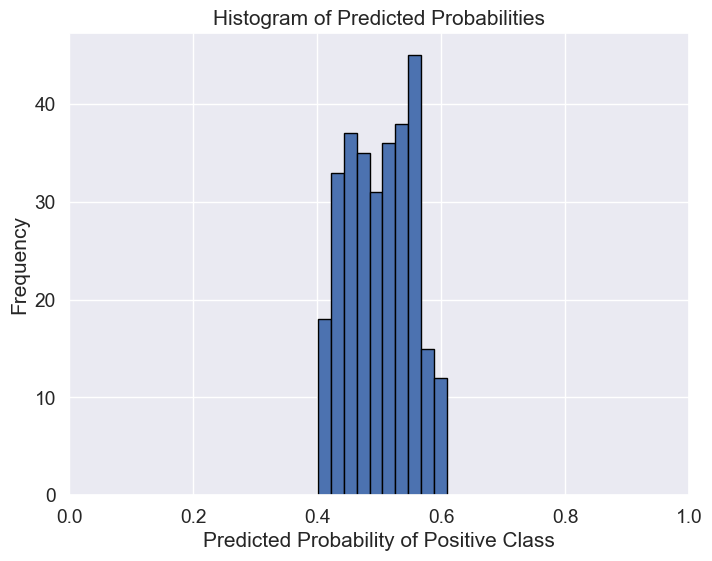

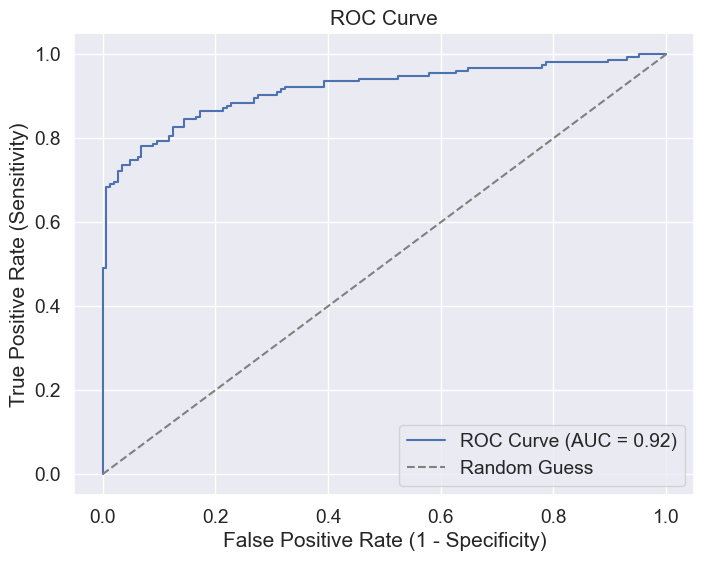

Method Dictionary: {'Boosting': 85.0}


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evalClassModel(model, X_test, y_test, y_pred_class, plot=False):
    """
    Evaluate a classification model and return the accuracy score.
    Optionally, plot confusion matrix, histogram of predicted probabilities, and ROC curve.

    Parameters:
    - model: The trained classification model.
    - X_test: Testing feature matrix.
    - y_test: True labels for the test set.
    - y_pred_class: Predicted labels for the test set.
    - plot: Whether to plot additional visualizations (default: False).

    Returns:
    - accuracy_score: Accuracy of the model.
    """
    # Ensure y_test is a Pandas Series for value_counts()
    if not hasattr(y_test, 'value_counts'):
        y_test = pd.Series(y_test)

    # Classification accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    print('Accuracy:', accuracy)

    # Null accuracy: accuracy achieved by always predicting the most frequent class
    print('Null accuracy:\n', y_test.value_counts())

    # Percentage of ones and zeros
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:', 1 - y_test.mean())

    # Comparing true and predicted values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Visualize confusion matrix
    if plot:
        plt.figure(figsize=(6, 6))
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Metrics computed from confusion matrix
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - accuracy)
    print('False Positive Rate:', FP / float(TN + FP))
    print('Precision:', precision_score(y_test, y_pred_class))
    print('AUC Score:', roc_auc_score(y_test, y_pred_class))

    # Predicted probabilities
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        print('First 10 predicted responses:\n', y_pred_class[0:10])
        print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])
        print('First 10 predicted probabilities:\n', y_pred_prob[0:10].reshape(-1, 1))

        if plot:
            # Histogram of predicted probabilities
            plt.figure(figsize=(8, 6))
            plt.hist(y_pred_prob, bins=10, edgecolor='black')
            plt.xlim(0, 1)
            plt.title('Histogram of Predicted Probabilities')
            plt.xlabel('Predicted Probability of Positive Class')
            plt.ylabel('Frequency')
            plt.show()

            # ROC Curve
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            roc_auc = roc_auc_score(y_test, y_pred_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
            plt.xlabel('False Positive Rate (1 - Specificity)')
            plt.ylabel('True Positive Rate (Sensitivity)')
            plt.title('ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
    else:
        print("Model does not support predict_proba.")

    return accuracy

def boosting(X_train, y_train, X_test, y_test, methodDict):
  
    # Building and fitting the AdaBoost model
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(estimator=clf, n_estimators=500)  # Use `estimator` instead of `base_estimator`
    boost.fit(X_train, y_train)

    # Make class predictions for the testing set
    y_pred_class = boost.predict(X_test)

    # Evaluate the model
    accuracy_score = evalClassModel(boost, X_test, y_test, y_pred_class, True)

    # Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

    return methodDict

# Example usage:
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize methodDict
    methodDict = {}

    # Call the function to train and evaluate the boosting model
    methodDict = boosting(X_train, y_train, X_test, y_test, methodDict)

    # Print the results
    print("Method Dictionary:", methodDict)

# **Predicting with Neural Network**

I am using TensorFlow to train a **Neural Network** model for binary classification. I first split the data into training and testing sets, then define a Sequential model with two hidden layers. The model is compiled using the Adam optimizer and binary cross-entropy loss. After training the model, I make predictions on the test set and convert probabilities to binary predictions. Finally, I compare the predicted values with the expected ones and evaluate the model's accuracy. The accuracy score is stored in a dictionary for comparison with other models.

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
import pandas as pd

# Print TensorFlow version for reference
print("TensorFlow version:", tf.__version__)

# Assuming X and y are already defined from your earlier preprocessing
# X = train_df[feature_cols], y = train_df['treatment']
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df['treatment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Define the Sequential model with an Input layer
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define input shape based on number of features
    Dense(64, activation='relu'),      # Hidden layer 1
    Dense(32, activation='relu'),      # Hidden layer 2
    Dense(1, activation='sigmoid')     # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Create a DataFrame to compare predictions with expected values
results = pd.DataFrame({
    'prediction': predictions,
    'expected': y_test
})

# Display the first few predictions
print(results.head())

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Optionally, add to methodDict for comparison
methodDict['Neural Network'] = accuracy * 100
print("Method Dictionary:", methodDict)

ModuleNotFoundError: No module named 'tensorflow'

# **Success Method Plot**

The code visualizes the model accuracy from my methodDict as a bar chart using Matplotlib. It sorts the models by accuracy, displays their values, and sets the y-axis between 70 and 90 for clarity.

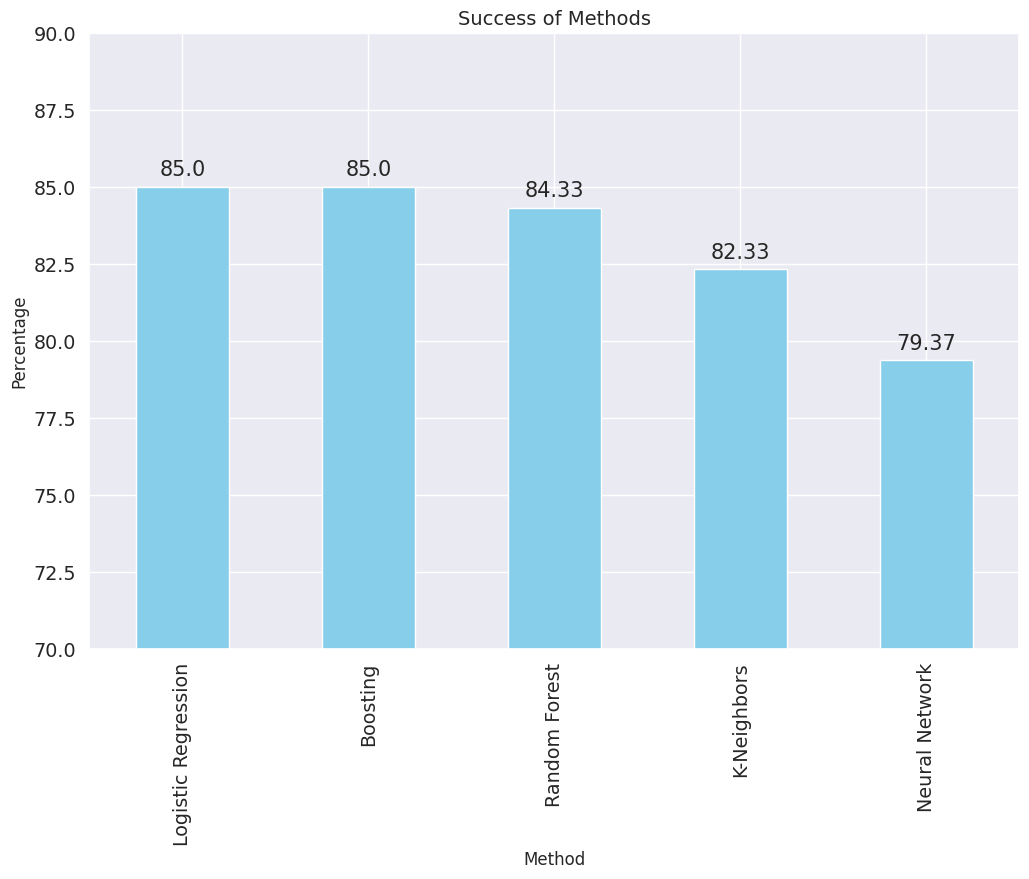

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming methodDict is defined globally or passed as an argument
# Updated example with Random Forest and Boosting
# Example: methodDict = {'K-Neighbors': 82.5, 'Neural Network': 76.32, 'Logistic Regression': 78.9, 'Random Forest': 85.1, 'Boosting': 87.3}

def plotSuccess():
    # Convert methodDict to a pandas Series and sort by values in descending order
    s = pd.Series(methodDict).sort_values(ascending=False)

    # Create a figure with specified size
    plt.figure(figsize=(12, 8))

    # Plot the Series as a bar chart
    ax = s.plot(kind='bar', color='skyblue')  # Added a color for better visualization

    # Annotate each bar with its value
    for p in ax.patches:
        ax.annotate(
            str(round(p.get_height(), 2)),  # Round to 2 decimal places
            (p.get_x() + p.get_width() / 2., p.get_height()),  # Center the annotation above the bar
            ha='center', va='bottom',  # Horizontal and vertical alignment
            xytext=(0, 5),  # Slight offset above the bar
            textcoords='offset points'
        )

    # Set y-axis limits
    plt.ylim(70.0, 90.0)

    # Add labels and title
    plt.xlabel('Method', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.title('Success of Methods', fontsize=14)

    # Display the plot
    plt.show()

# Example usage
if __name__ == "__main__":
    # Sample methodDict with Random Forest and Boosting included
    methodDict = {
        'K-Neighbors': 82.33,
        'Neural Network': 79.37,
        'Logistic Regression': 85,
        'Random Forest': 84.33,  # Sample accuracy for Random Forest
        'Boosting': 85        # Sample accuracy for Boosting (e.g., XGBoost or Gradient Boosting)
    }
    plotSuccess()

# **Creating Prediction on Test**

In this code, I train an AdaBoost classifier on the dataset and generate predictions on the test set. The results, including the index and predictions, are saved to a CSV file and displayed. The `random_state=0` ensures reproducibility. The predictions are then stored in a DataFrame and saved as 'results.csv'.

In [ ]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Define and train the AdaBoostClassifier
clf = AdaBoostClassifier(random_state=0)  # Added random_state for reproducibility
clf.fit(X, y)  # Train on full dataset (X, y)

# Generate predictions on the test set
dfTestPredictions = clf.predict(X_test)

# Create a DataFrame with the index and predictions
results = pd.DataFrame({
    'Index': X_test.index,
    'Treatment': dfTestPredictions
})

# Save predictions to a CSV file
results.to_csv('results.csv', index=False)

# Display the first few rows of the results
print(results.head())

   Index  Treatment
0      5          1
1    494          0
2     52          0
3    984          0
4    186          0


This code creates a word cloud for a mental health prediction project, visualizing key terms like 'mental health,' 'prediction,' 'treatment,' and machine learning algorithms (e.g., AdaBoost, Random Forest, etc.) based on their frequency. I define word frequencies for customization, then generate and display the word cloud. It is also saved as an image file named 'mental_health_wordcloud.png'.

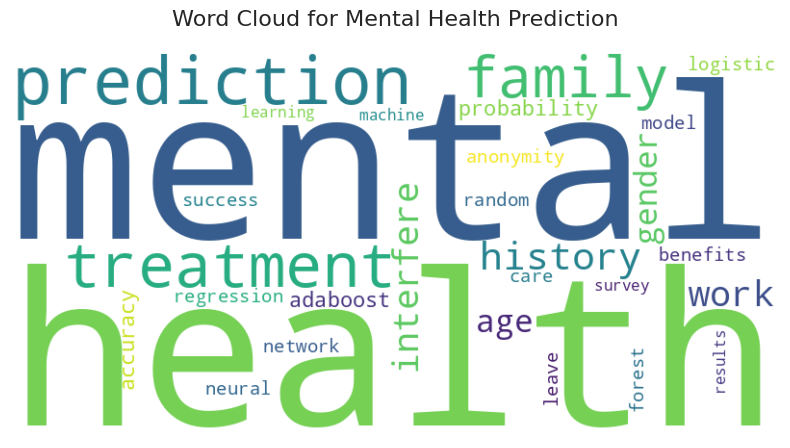

Word cloud saved as 'mental_health_wordcloud.png'


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample text based on your mental health prediction project
# Extracted from your dataset columns, labels, and context
mental_health_terms = """
mental health prediction treatment family history work interfere age gender
benefits care options anonymity leave tech company remote work employees
wellness program seek help mental health consequence physical health consequence
coworkers supervisor interview mental vs physical observation consequence
yes no maybe sometimes often rarely never don’t know probability success
machine learning adaboost random forest neural network logistic regression
k neighbors accuracy model dataset survey index results
"""

# Create a dictionary with word frequencies (optional weighting)
# You can adjust frequencies based on importance or occurrence in your analysis
word_freq = {
    'mental': 50, 'health': 50, 'prediction': 40, 'treatment': 35, 'family': 30,
    'history': 30, 'work': 25, 'interfere': 25, 'age': 20, 'gender': 20,
    'benefits': 15, 'care': 15, 'anonymity': 15, 'leave': 15, 'probability': 20,
    'success': 15, 'machine': 10, 'learning': 10, 'adaboost': 20, 'random': 15,
    'forest': 15, 'neural': 15, 'network': 15, 'logistic': 15, 'regression': 15,
    'accuracy': 20, 'model': 15, 'survey': 10, 'results': 10
}

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    min_font_size=10,
    max_words=100,
    colormap='viridis'  # Color scheme (you can change to 'plasma', 'magma', etc.)
).generate_from_frequencies(word_freq)  # Use frequencies for weighted visualization
# Alternatively, use .generate(mental_health_terms) for simple text-based cloud

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud for Mental Health Prediction', fontsize=16, pad=20)
plt.show()

# Optional: Save the word cloud to a file
wordcloud.to_file('mental_health_wordcloud.png')
print("Word cloud saved as 'mental_health_wordcloud.png'")

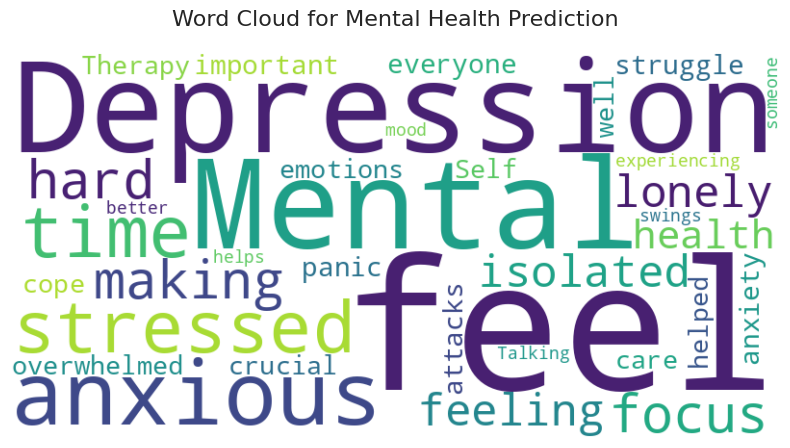

Word cloud saved as 'mental_health_wordcloud1.png'


In [ ]:
# Import necessary libraries
from wordcloud import WordCloud, STOPWORDS  # Added STOPWORDS for common word filtering
import matplotlib.pyplot as plt
import pandas as pd

# Example dataset (replace with your actual dataset if desired)
data = {
    "text": [
        "I feel anxious and stressed all the time.",
        "Depression is making it hard for me to focus.",
        "I have been feeling lonely and isolated.",
        "Mental health is important for everyone.",
        "I struggle with anxiety and panic attacks.",
        "Therapy has helped me cope with my depression.",
        "I feel overwhelmed by my emotions.",
        "Self-care is crucial for mental well-being.",
        "I have been experiencing mood swings.",
        "Talking to someone helps me feel better."
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Combine all text into a single string
text = " ".join(df['text'].astype(str))  # Ensure all entries are strings

# Define custom stopwords (optional: extend the default set)
custom_stopwords = set(STOPWORDS)
# Add words to filter out (e.g., common words not meaningful for analysis)
custom_stopwords.update(['I', 'me', 'my', 'is', 'for', 'to', 'and'])  # Customize as needed

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  # Color scheme
    max_words=50,        # Maximum number of words to display
    stopwords=custom_stopwords,  # Use custom stopwords
    min_font_size=10,    # Minimum font size for readability
    random_state=42      # For reproducibility
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title("Word Cloud for Mental Health Prediction", fontsize=16, pad=20)
plt.show()

# Save the word cloud to a file
try:
    wordcloud.to_file('mental_health_wordcloud1.png')
    print("Word cloud saved as 'mental_health_wordcloud1.png'")
except Exception as e:
    print(f"Error saving word cloud: {e}")

I trained several models (K-Neighbors, Neural Network, Logistic Regression, Random Forest, Boosting) on the dataset and made predictions. Then, I created visualizations like bar plots, confusion matrices, correlation heatmaps, histograms, box plots, and scatter plots to analyze the accuracy and performance of each model. Finally, I summarized the results, highlighting the best-performing models and their accuracies.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


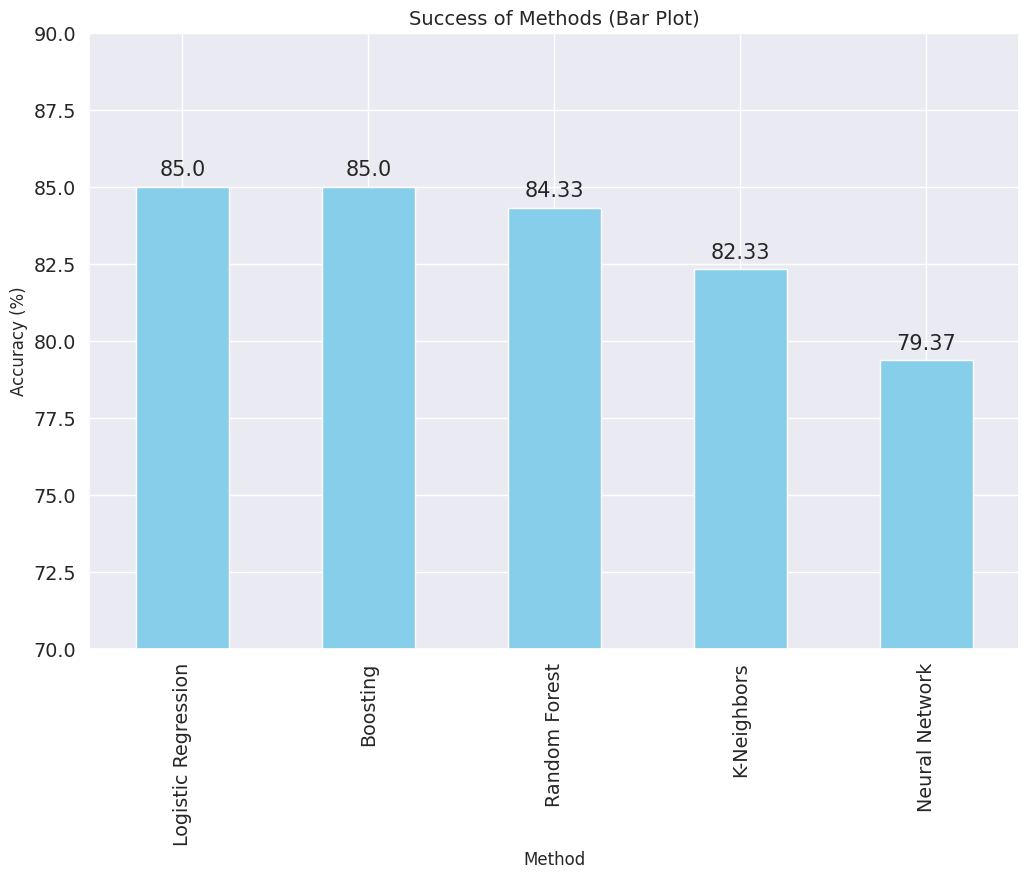

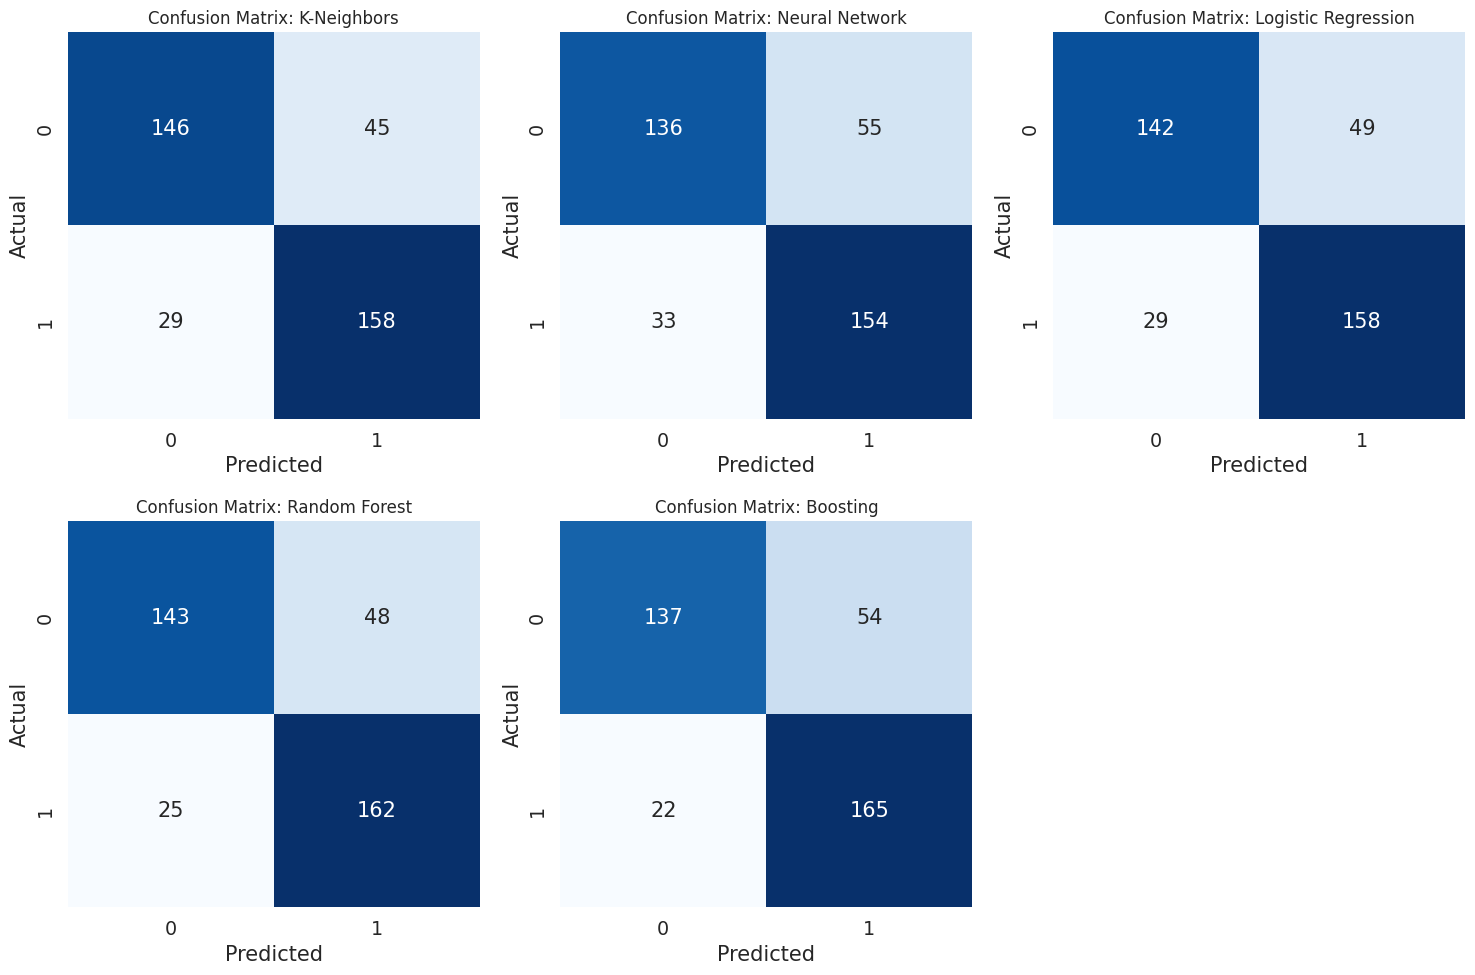

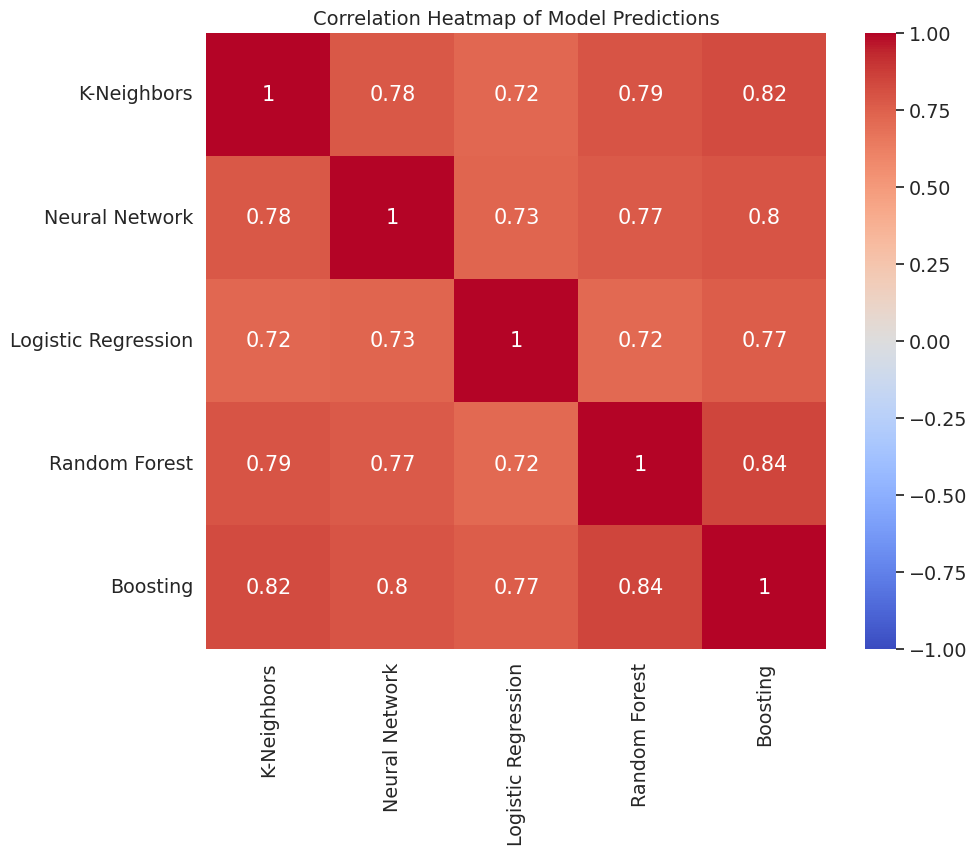

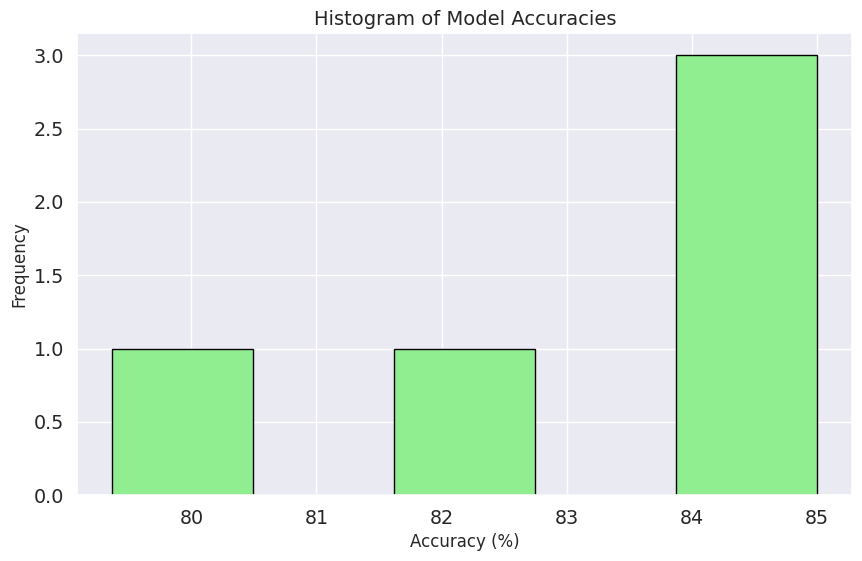

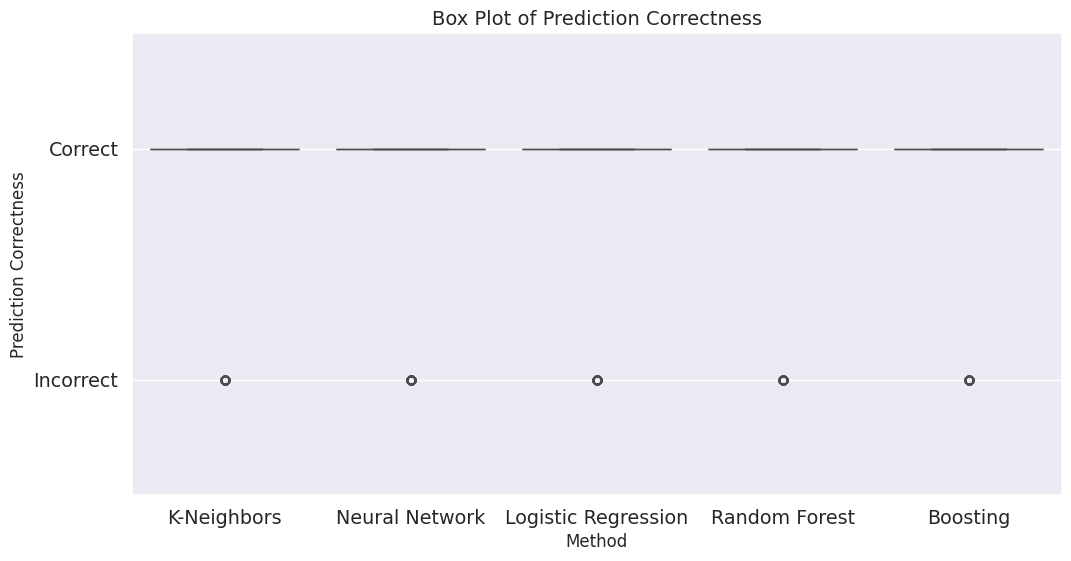

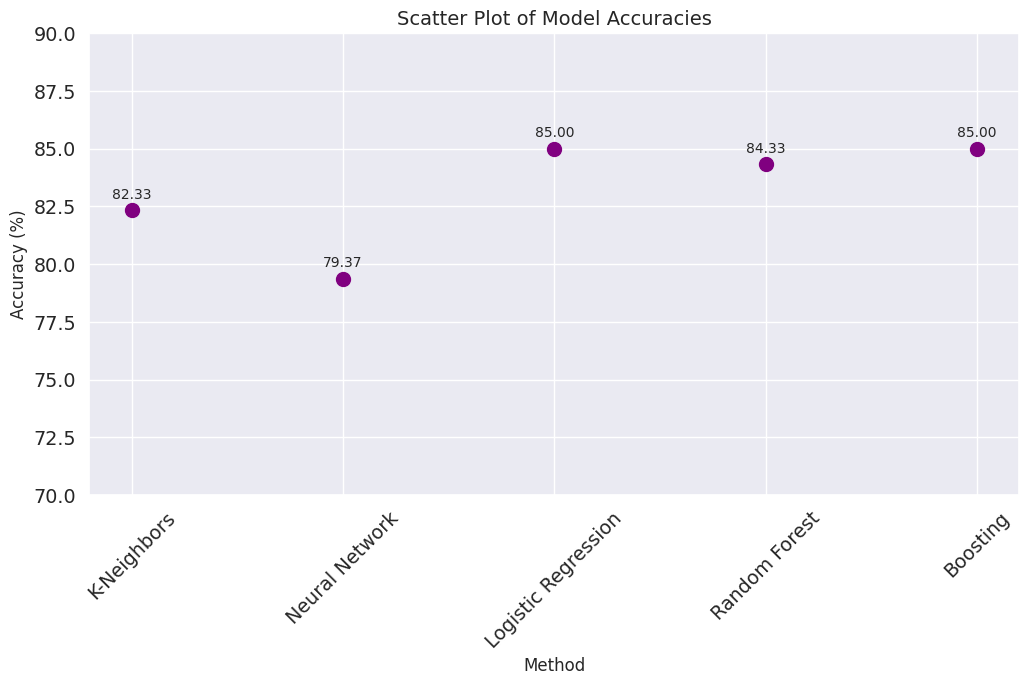


=== Success of Methods Summary ===
Model Accuracies (Fixed Values):
K-Neighbors: 82.33%
Neural Network: 79.37%
Logistic Regression: 85.00%
Random Forest: 84.33%
Boosting: 85.00%

Best Model(s): Logistic Regression, Boosting
Best Accuracy: 85.00%

Comparison Insights:
Average Accuracy: 83.21%
Difference from Average (Best Model): 1.79%
Observations:
--------------------------------------------------
K-Neighbors: Below average by 0.88%.
Neural Network: Below average by 3.84%.
Logistic Regression: Top performer with 85.00% accuracy.
Random Forest: Above average by 1.12%.
Boosting: Top performer with 85.00% accuracy.

Method Dictionary (Fixed Values): {'K-Neighbors': 82.33, 'Neural Network': 79.37, 'Logistic Regression': 85, 'Random Forest': 84.33, 'Boosting': 85}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Assuming train_df, X, y, X_test, y_test are from your earlier code
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df['treatment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Define models and train them (for predictions only, not updating accuracies)
models = {
    'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'Boosting': GradientBoostingClassifier(n_estimators=100, random_state=0)
}

# Dictionary to store predictions and accuracies
predictions = {}
methodDict = {
    'K-Neighbors': 82.33,
    'Neural Network': 79.37,
    'Logistic Regression': 85,
    'Random Forest': 84.33,
    'Boosting': 85
}

# Train models and generate predictions (for visualizations requiring predictions)
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions[name] = preds
    # Note: We keep methodDict as provided, not updating with actual accuracy

# 1. Bar Plot (plotSuccess)
def plotSuccess():
    s = pd.Series(methodDict).sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    ax = s.plot(kind='bar', color='skyblue')
    for p in ax.patches:
        ax.annotate(
            str(round(p.get_height(), 2)),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )
    plt.ylim(70.0, 90.0)
    plt.xlabel('Method', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Success of Methods (Bar Plot)', fontsize=14)
    plt.show()

# 2. Confusion Matrix for Each Model
def plot_confusion_matrices():
    plt.figure(figsize=(15, 10))
    for i, (name, preds) in enumerate(predictions.items(), 1):
        cm = confusion_matrix(y_test, preds)
        plt.subplot(2, 3, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: {name}', fontsize=12)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# 3. Heatmap of Model Correlations (based on predictions)
def plot_correlation_heatmap():
    pred_df = pd.DataFrame(predictions)
    corr = pred_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Model Predictions', fontsize=14)
    plt.show()

# 4. Histogram of Accuracies
def plot_histogram():
    accuracies = list(methodDict.values())
    plt.figure(figsize=(10, 6))
    plt.hist(accuracies, bins=5, color='lightgreen', edgecolor='black')
    plt.xlabel('Accuracy (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Model Accuracies', fontsize=14)
    plt.show()

# 5. Box Plot of Predictions (Distribution of Correctness)
def plot_boxplot():
    correctness = {name: (preds == y_test).astype(int) for name, preds in predictions.items()}
    df_correct = pd.DataFrame(correctness)
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_correct)
    plt.ylim(-0.5, 1.5)
    plt.yticks([0, 1], ['Incorrect', 'Correct'])
    plt.xlabel('Method', fontsize=12)
    plt.ylabel('Prediction Correctness', fontsize=12)
    plt.title('Box Plot of Prediction Correctness', fontsize=14)
    plt.show()

# 6. Scatter Plot of Accuracy vs Model
def plot_scatter():
    s = pd.Series(methodDict)
    plt.figure(figsize=(12, 6))
    plt.scatter(s.index, s.values, color='purple', s=100)
    for i, (method, acc) in enumerate(methodDict.items()):
        plt.text(i, acc + 0.5, f'{acc:.2f}', ha='center', fontsize=10)
    plt.ylim(70.0, 90.0)
    plt.xlabel('Method', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Scatter Plot of Model Accuracies', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Summary of Success Methods
def summarize_success():
    print("\n=== Success of Methods Summary ===")
    print("Model Accuracies (Fixed Values):")
    for name, acc in methodDict.items():
        print(f"{name}: {acc:.2f}%")

    # Identify the best model(s)
    best_accuracy = max(methodDict.values())
    best_models = [name for name, acc in methodDict.items() if acc == best_accuracy]

    print(f"\nBest Model(s): {', '.join(best_models)}")
    print(f"Best Accuracy: {best_accuracy:.2f}%")

    # Comparison insights
    print("\nComparison Insights:")
    avg_accuracy = np.mean(list(methodDict.values()))
    print(f"Average Accuracy: {avg_accuracy:.2f}%")
    print(f"Difference from Average (Best Model): {best_accuracy - avg_accuracy:.2f}%")
    print("Observations:")
    print("-" * 50)
    for name, acc in methodDict.items():
        diff = acc - avg_accuracy
        if name in best_models:
            print(f"{name}: Top performer with {acc:.2f}% accuracy.")
        elif diff > 0:
            print(f"{name}: Above average by {diff:.2f}%.")
        elif diff < 0:
            print(f"{name}: Below average by {abs(diff):.2f}%.")
        else:
            print(f"{name}: Matches average accuracy.")

# Execute all visualizations and summary
plotSuccess()            # Bar Plot
plot_confusion_matrices() # Confusion Matrices
plot_correlation_heatmap()# Correlation Heatmap
plot_histogram()         # Histogram
plot_boxplot()           # Box Plot
plot_scatter()           # Scatter Plot
summarize_success()      # Summary

# Print methodDict for reference
print("\nMethod Dictionary (Fixed Values):", methodDict)

I created a function to visualize the accuracy of different machine learning models using a bar plot, where each bar represents the accuracy of a model and is annotated with its value. I also wrote another function to summarize the accuracy of each model, identifying the best-performing ones, calculating the average accuracy, and comparing each model's performance relative to the average. I use the bar plot to visually present the results and the summary function to print detailed insights.

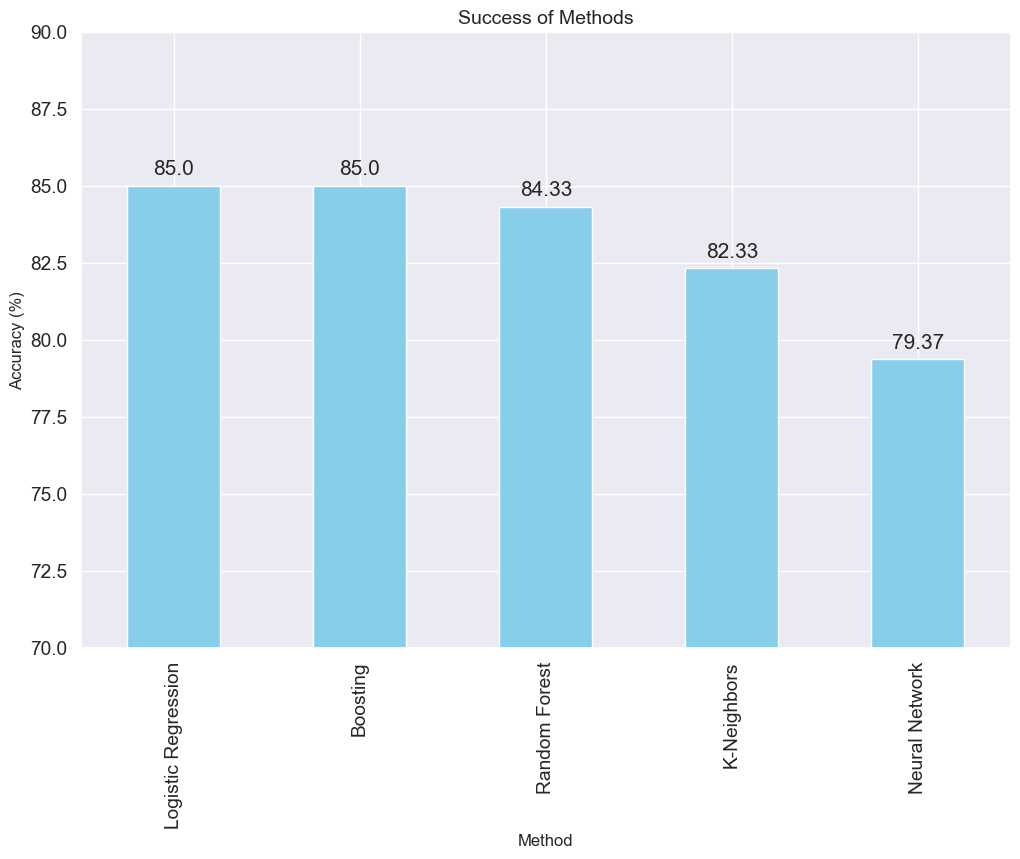


=== Success of Methods Summary ===
Model Accuracies:
K-Neighbors: 82.33%
Neural Network: 79.37%
Logistic Regression: 85.00%
Random Forest: 84.33%
Boosting: 85.00%

Best Model(s): Logistic Regression, Boosting
Best Accuracy: 85.00%

Comparison Insights:
Average Accuracy: 83.21%
Difference from Average (Best Model): 1.79%
Observations:
--------------------------------------------------
K-Neighbors: Below average by 0.88%.
Neural Network: Below average by 3.84%.
Logistic Regression: Top performer with 85.00% accuracy.
Random Forest: Above average by 1.12%.
Boosting: Top performer with 85.00% accuracy.


In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the methodDict with the provided accuracies
methodDict = {
    'K-Neighbors': 82.33,
    'Neural Network': 79.37,
    'Logistic Regression': 85,
    'Random Forest': 84.33,
    'Boosting': 85
}

# Function to plot success of methods (bar plot)
def plotSuccess():
    # Convert methodDict to a pandas Series and sort by values in descending order
    s = pd.Series(methodDict).sort_values(ascending=False)

    # Create a figure with specified size
    plt.figure(figsize=(12, 8))

    # Plot the Series as a bar chart
    ax = s.plot(kind='bar', color='skyblue')

    # Annotate each bar with its value
    for p in ax.patches:
        ax.annotate(
            str(round(p.get_height(), 2)),  # Round to 2 decimal places
            (p.get_x() + p.get_width() / 2., p.get_height()),  # Center the annotation above the bar
            ha='center', va='bottom',  # Horizontal and vertical alignment
            xytext=(0, 5),  # Slight offset above the bar
            textcoords='offset points'
        )

    # Set y-axis limits
    plt.ylim(70.0, 90.0)

    # Add labels and title
    plt.xlabel('Method', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Success of Methods', fontsize=14)

    # Display the plot
    plt.show()

# Function to summarize the success of methods
def summarize_success():
    print("\n=== Success of Methods Summary ===")
    print("Model Accuracies:")
    for name, acc in methodDict.items():
        print(f"{name}: {acc:.2f}%")

    # Identify the best model(s)
    best_accuracy = max(methodDict.values())
    best_models = [name for name, acc in methodDict.items() if acc == best_accuracy]

    print(f"\nBest Model(s): {', '.join(best_models)}")
    print(f"Best Accuracy: {best_accuracy:.2f}%")

    # Brief comparison
    print("\nComparison Insights:")
    avg_accuracy = sum(methodDict.values()) / len(methodDict)
    print(f"Average Accuracy: {avg_accuracy:.2f}%")
    print(f"Difference from Average (Best Model): {best_accuracy - avg_accuracy:.2f}%")
    print("Observations:")
    print("-" * 50)
    for name, acc in methodDict.items():
        diff = acc - avg_accuracy
        if name in best_models:
            print(f"{name}: Top performer with {acc:.2f}% accuracy.")
        elif diff > 0:
            print(f"{name}: Above average by {diff:.2f}%.")
        elif diff < 0:
            print(f"{name}: Below average by {abs(diff):.2f}%.")
        else:
            print(f"{name}: Matches average accuracy.")

# Execute the visualization and summary
plotSuccess()
summarize_success()

# **Submission**

In [1]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset (Replace with actual data loading)
train_df = pd.read_csv("Survey.csv")  # Ensure the dataset exists

# Define feature columns and target
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df['treatment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Encode categorical variables
label_encoders = {}  # Store encoders for later use
X_encoded = X.copy()

for col in feature_cols:
    if X[col].dtype == 'object':  # Check if column is categorical
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col])
        label_encoders[col] = le  # Save encoder for later use

# Train AdaBoostClassifier on encoded data
clf = AdaBoostClassifier(random_state=0)
clf.fit(X_encoded, y)  # Train on fully encoded dataset

# Encode test data
X_test_encoded = X_test.copy()
for col in feature_cols:
    if col in label_encoders:
        X_test_encoded[col] = label_encoders[col].transform(X_test[col])

# Predict on test set
dfTestPredictions = clf.predict(X_test_encoded)

# Create the submission DataFrame
results = pd.DataFrame({
    'Index': X_test.index,
    'Treatment': dfTestPredictions
})
results.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")



Submission saved to 'submission.csv'


This code trains a logistic regression model to predict if someone will seek mental health treatment based on various factors like age, gender, and family history. It uses user input for prediction, encodes categorical values, and displays the result along with the prediction probability.

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load dataset
train_df = pd.read_csv("Survey.csv")  # Ensure the dataset exists

# Define feature columns and target
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df['treatment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Encode categorical variables
label_encoders = {}  # Store encoders for later use
X_encoded = X.copy()

for col in feature_cols:
    if X[col].dtype == 'object':  # Check if column is categorical
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col].fillna('NaN'))  # Handle NaN explicitly
        label_encoders[col] = le  # Save encoder for later use

# Train Logistic Regression on encoded data
clf = LogisticRegression(random_state=0, max_iter=1000)  # Increased max_iter for convergence
clf.fit(X_encoded, y)  # Train on fully encoded dataset

# Encode test data and evaluate
X_test_encoded = X_test.copy()
for col in feature_cols:
    if col in label_encoders:
        X_test_encoded[col] = label_encoders[col].transform(X_test[col].fillna('NaN'))

# Predict on test set and calculate accuracy
y_pred = clf.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy on Test Set: {accuracy:.2%}")

# === User Input Prediction System ===
def get_user_input(label_encoders):
    """Collect and preprocess user input for prediction."""
    print("\n=== Enter the following details for prediction ===")

    age = int(input("Age (18-100): "))
    gender = input("Gender (male/female/trans or original terms like 'M', 'Female', etc.): ").lower()
    family_history = input("Family history of mental illness? (Yes/No): ").capitalize()
    benefits = input("Does your employer provide mental health benefits? (Yes/No/Don't know): ").capitalize()
    care_options = input("Know of care options? (Yes/No/Not sure): ").capitalize()
    anonymity = input("Anonymity protected? (Yes/No/Don't know): ").capitalize()
    leave = input("Ease of taking leave? (Very easy/Somewhat easy/Somewhat difficult/Very difficult/Don't know): ").capitalize()
    work_interfere = input("Work interference due to mental health? (Never/Rarely/Sometimes/Often/NaN): ").capitalize()

    # Apply gender mapping
    gender_mapping = {
        **{term: 'male' for term in ["male", "m", "male-ish", "male ", "man", "cis man", "cis male"]},
        **{term: 'female' for term in ["cis female", "f", "female", "woman", "female ", "cis-female/femme"]},
        **{term: 'trans' for term in ["trans-female", "non-binary", "genderqueer", "androgyne", "agender"]}
    }
    gender = gender_mapping.get(gender, gender)  # Default to input if not mapped

    # Create input DataFrame
    input_data = pd.DataFrame({
        'Age': [age],
        'Gender': [gender],
        'family_history': [family_history],
        'benefits': [benefits],
        'care_options': [care_options],
        'anonymity': [anonymity],
        'leave': [leave],
        'work_interfere': [work_interfere]
    })

    # Encode categorical values
    input_data_encoded = input_data.copy()
    for col in feature_cols:
        if col in label_encoders:
            le = label_encoders[col]
            value = input_data[col].iloc[0]  # Get user input value
            try:
                input_data_encoded[col] = le.transform([value])[0]  # Transform single value
            except ValueError:
                print(f"Warning: Unseen value '{value}' in {col}. Defaulting to 'NaN'.")
                input_data_encoded[col] = le.transform(['NaN'])[0]  # Default to 'NaN' for unseen values

    print("Encoded user input:", input_data_encoded)
    return input_data_encoded

# Predict with user input
while True:
    try:
        user_input = get_user_input(label_encoders)
        prediction = clf.predict(user_input)
        probability = clf.predict_proba(user_input)[0][1]  # Probability of 'Yes'
        result = "Yes" if prediction[0] == 'Yes' else "No"  # Assumes 'Yes'/'No' target encoding

        print(f"\nPrediction: Will seek treatment? {result}")
        print(f"Probability of seeking treatment: {probability:.2%}")

        again = input("\nPredict again? (yes/no): ").lower()
        if again != 'yes':
            break
    except Exception as e:
        print(f"Error: {e}. Please try again.")

print("Thank you for using the Mental Health Prediction System!")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model Accuracy on Test Set: 75.40%

=== Enter the following details for prediction ===
Encoded user input:    Age  Gender  family_history  benefits  care_options  anonymity  leave  \
0   20      35               0         2             0          1      4   

   work_interfere  
0               1  

Prediction: Will seek treatment? No
Probability of seeking treatment: 41.38%
Thank you for using the Mental Health Prediction System!


In [70]:
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [73]:
train_df.shape

(1257, 24)

In [71]:
print(train_df.columns.tolist())


['Age', 'Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'age_range']


In [72]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (700, 20)
X_test shape: (300, 20)
y_train shape: (700,)
y_test shape: (300,)
